In [2]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import zscore
from scipy.integrate import cumtrapz
import data_processing as dp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pywt
import h5py
from nitime.algorithms import autoregressive
from sklearn.preprocessing import StandardScaler,normalize,MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor as LOF
#from sklearn.ensemble import IsolationForest
import joblib
from PyEMD import EMD
import time

In [3]:
import imp
imp.reload(dp)

<module 'data_processing' from 'E:\\Document\\jupyter\\Master Thesis\\data_processing.py'>

In [2]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        depth = len(dirname.split(os.path.sep))
        if depth == 2:
            print(os.path.join(dirname,filename))

.\data\file_name.txt
.\data\G04_FoG_trial_1_emg.csv
.\data\G04_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_1_emg.csv
.\data\G06_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_3_emg.csv
.\data\G07_Freezing_Trial1_trial_1_emg.csv
.\data\G08_FoG_1_trial_1_emg.csv
.\data\G08_FoG_2_trial_1_emg.csv
.\data\G11_FoG_trial_1_emg.csv
.\data\G11_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_3_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_3_emg.csv
.\data\P551_M050_2_A_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_2_emg.csv
.\data\some_of_rest.txt


In [47]:
emg_data = pd.read_csv('.\data\G08_FoG_1_trial_1_emg.csv')
emg_data2 = pd.read_csv('.\data\G04_FoG_trial_1_emg.csv')

In [5]:
emg_data.head()

Time  Label1  Label2  LEFT_TA  LEFT_TS  LEFT_BF  LEFT_RF  RIGHT_TA  \
0  0.000       0       0       -3        2     -4.0     -1.0       0.0   
1  0.001       0       0       -5       10      0.0     -2.0      -4.0   
2  0.002       0       0       -6       11      1.0      0.0      -4.0   
3  0.003       0       0        0       -2      0.0     -3.0      -6.0   
4  0.004       0       0        0       -8     -3.0     -3.0      -4.0   

   RIGHT_TS  RIGHT_BF  RIGHT_RF  
0       2.0       1.0      -2.0  
1       0.0      -7.0      -2.0  
2      -1.0      -2.0      -3.0  
3      -2.0      -5.0      -8.0  
4      -3.0       0.0       2.0

In [6]:
emg_data2.head()

Time  Label1  Label2  LEFT_TA  LEFT_TS  LEFT_BF  LEFT_RF  RIGHT_TA  \
0  0.000       0       0      -14       -4       -4       -1        -9   
1  0.001       0       0       -5       -4       -4       -4        -6   
2  0.002       0       0        6        0       -9        4        -6   
3  0.003       0       0       28        1       -1       -1         1   
4  0.004       0       0       43        3       -2        0         1   

   RIGHT_TS  RIGHT_BF  RIGHT_RF  
0        -2       1.0      -1.0  
1        -1       0.0       6.0  
2        -6       0.0      -2.0  
3         2      -5.0       2.0  
4         2       3.0       1.0

In [7]:
emg_data.Label2.describe()

count    23301.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Label2, dtype: float64

In [3]:
emg_data2 = emg_data2.fillna({'LEFT_TA':emg_data.RIGHT_TA.mean(),
                           'LEFT_TS':emg_data.RIGHT_TS.mean(),
                           'LEFT_BF':emg_data.LEFT_BF.mean(),
                           'LEFT_RF':emg_data.LEFT_RF.mean(),
                          # 'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                           #'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                           #'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                           #'RIGHT_RF':emg_data.RIGHT_RF.mean()})
emg_data2.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [54]:
emg_data2.isna().sum()
len(emg_data2)

72912

In [47]:
emg_data2.isna().sum()

Time       0
Label1     0
Label2     0
LEFT_TA    0
LEFT_TS    0
LEFT_BF    0
LEFT_RF    0
dtype: int64

In [5]:
df = pd.read_csv('./useful_data_label.csv',index_col=0)
df2 = pd.read_csv('./unuseful_data_label.csv',index_col=0)
df2.columns

Index(['G02_Walking_trial_1_emg.csv', 'G03_Walking_trial_1_emg.csv',
       'G03_Walking_trial_2_emg.csv',
       'G05_Walking_struct_fixed_trial_1_emg.csv',
       'G05_Walking_struct_fixed_trial_2_emg.csv',
       'G05_Walking_struct_fixed_trial_3_emg.csv', 'G09_FoG_trial_1_emg.csv',
       'G09_FoG_trial_2_emg.csv', 'G09_FoG_trial_3_emg.csv',
       'G09_Walking_trial_2_emg.csv',
       ...
       'P940_M100_B_Walking_2_trial_2_emg.csv',
       'P940_M100_B_Walking_2_trial_6_emg.csv',
       'P940_MSham_A_FoG_trial_1_emg.csv', 'P940_MSham_A_FoG_trial_3_emg.csv',
       'P940_MSham_A_Walking_trial_2_emg.csv',
       'P940_MSham_A_Walking_trial_4_emg.csv',
       'P940_MSham_A_Walking_trial_6_emg.csv',
       'P940_MSham_B_Walking_trial_2_emg.csv',
       'P940_MSham_B_Walking_trial_4_emg.csv',
       'P940_MSham_B_Walking_trial_6_emg.csv'],
      dtype='object', length=161)

In [5]:
data.LEFT_TA.mean()

NameError: name 'data' is not defined

In [6]:
df2.columns[4]
pd.read_csv('./data/'+df.columns[0]).isna().sum()

Time            0
Label1          0
Label2          0
LEFT_TA        15
LEFT_TS        24
LEFT_BF         6
LEFT_RF         0
RIGHT_TA    56212
RIGHT_TS    56272
RIGHT_BF      102
RIGHT_RF       95
dtype: int64

{0, 1, 2, 6}


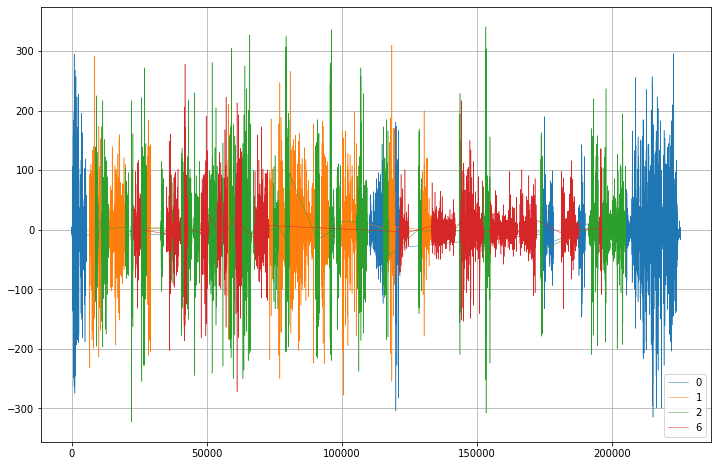

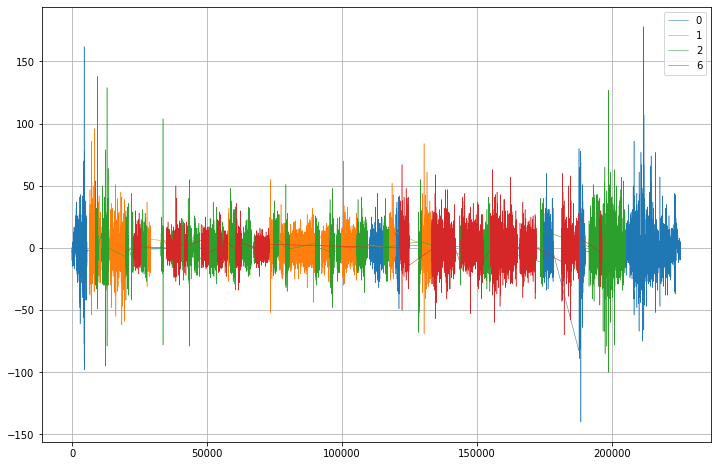

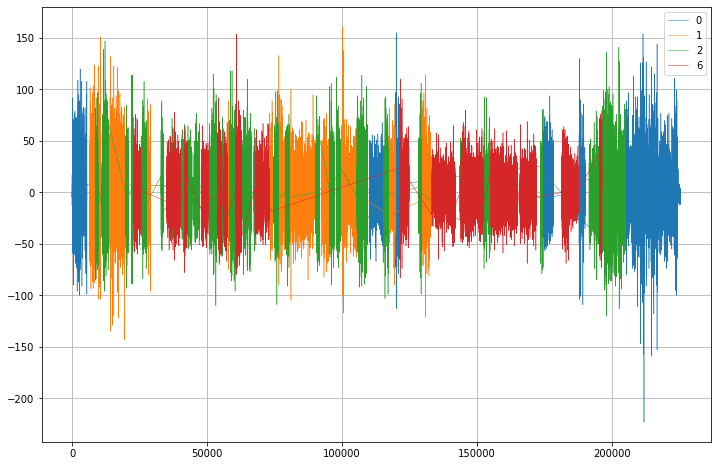

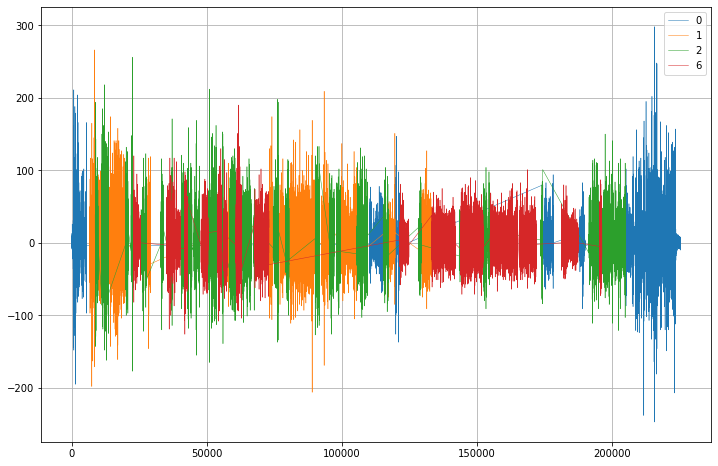

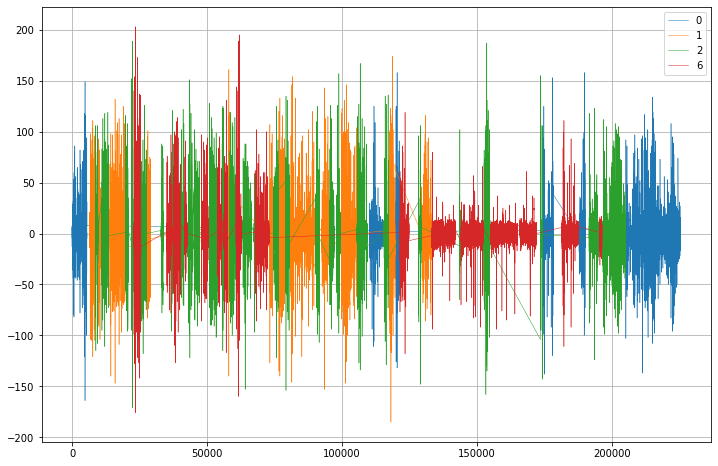

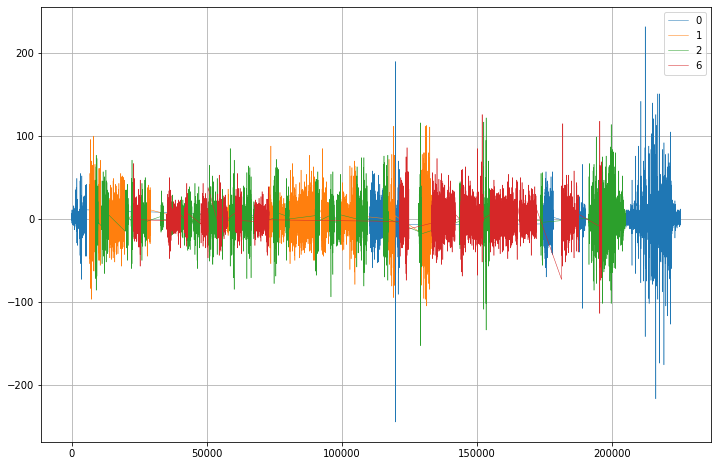

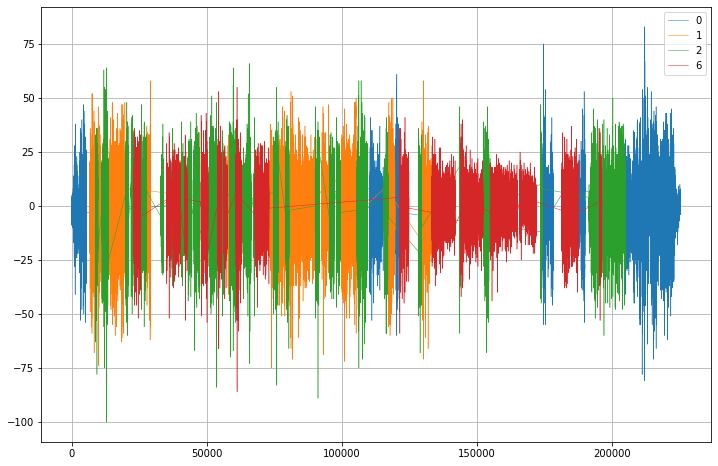

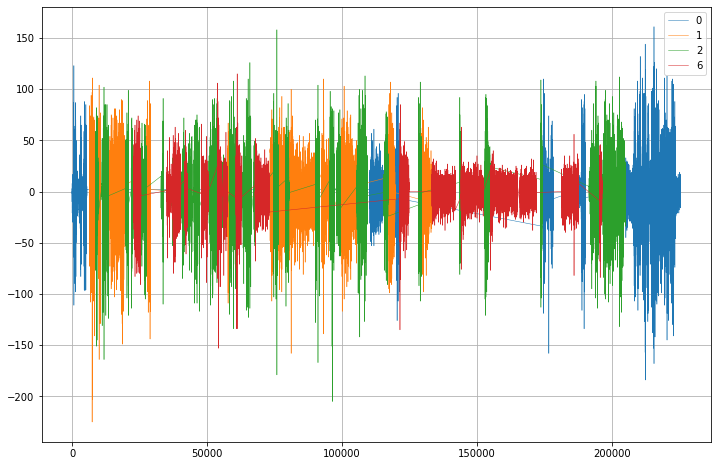

In [32]:
data = pd.read_csv('./data/'+df.columns[6])
#data = pd.read_csv('./data/正常/'+df2.columns[0])
"""data = data.fillna({'LEFT_TA':data.LEFT_TA.mean(),
                           'LEFT_TS':data.LEFT_TS.mean(),
                           'LEFT_BF':data.LEFT_BF.mean(),
                           'LEFT_RF':data.LEFT_RF.mean(),
                           'RIGHT_TA':data.RIGHT_TA.mean(),
                           'RIGHT_TS':data.RIGHT_TS.mean(),
                           'RIGHT_BF':data.RIGHT_BF.mean(),
                           'RIGHT_RF':data.RIGHT_RF.mean()})"""
data = data.dropna()
print(set(data.Label2))
fn = 15
wn=2*fn/1000
fn1 = 400
wn1=2*fn1/1000
#b, a = signal.butter(4, [wn,wn1], 'bandpass')
b, a = signal.butter(4, [wn1], 'lowpass')
#x_filter = signal.filtfilt(b, a, x[1,:,1])
sc = StandardScaler(with_mean=False)
#scs = []
m = 0
#x_filter = sc.fit_transform(np.array(data.iloc[:,3:]))
#data.iloc[:,3:] = sc.fit_transform(data.iloc[:,3:])
#data.iloc[:,3:] = normalize(data.iloc[:,3:])
for i in data.columns[3:]:
    plt.figure(figsize=(12,8))
    #data.iloc[:,3:] = normalize(data.iloc[:,3:])
    #ind_p = zscore(data.loc[:,i])>10
    #ind_n = zscore(data.loc[:,i])<-10
    #data.loc[~ind,i] = data.loc[ind,i].mean()
    #ind = (lof.fit_predict(np.array(data.loc[:,i])[:,np.newaxis]))==1
    #data.loc[ind_p,i] = data.loc[~ind_p,i].max()
    #data.loc[ind_n,i] = data.loc[~ind_n,i].max()
    #x_filter = signal.filtfilt(b, a, data.loc[:,i])
    #ind = abs(zscore(x_filter))<10
    #x_filter[ind_p]=x_filter[~ind_p].max()
    #x_filter[ind_n]=x_filter[~ind_n].min()
    #ind = (lof.fit_predict(x_filter[:,np.newaxis]))==1
    #x_filter[~ind] = x_filter[ind].mean()
    #x_filter = sc.fit_transform(np.array(data.loc[:,i])[:,np.newaxis])
    #sc = joblib.load('./model/scalar%d'%m)
    #x_filter = sc.transform(np.array(data.loc[:,i])[:,np.newaxis])
    m += 1
    #scs += [sc]
    #data.loc[:20000,i].plot(linewidth=0.5)
    #sns.lineplot(data.Time[:20000],x_filter[:20000],linewidth=0.3)
    for j in set(data.Label2):
        ind = (data.Label2 == j) & (data.Label1 == j)
        data.loc[ind,i].plot(linewidth=0.5)
        #sns.lineplot(data.Time[ind],x_filter[ind],linewidth=0.3)
        #plt.ylim((-200,200))
        #plt.xlim((0,4000))
        plt.grid(True)
        #sns.scatterplot(data.Time[ind],data.loc[ind,i],markers='.',alpha=0.5,size=0.1)
    plt.legend(set(data.Label2))

In [4]:
data

Time  Label1  Label2  LEFT_TA  LEFT_TS  LEFT_BF  LEFT_RF  RIGHT_TA  \
0         0.000       0       0    -10.0     -6.0      7.0     -1.0        -9   
1         0.001       0       0     -6.0     -6.0     12.0     -1.0        -1   
2         0.002       0       0      0.0      0.0      0.0     -1.0         0   
3         0.003       0       0    -32.0      2.0     -2.0      2.0         1   
4         0.004       0       0      9.0      3.0      0.0     -3.0         0   
...         ...     ...     ...      ...      ...      ...      ...       ...   
160812  160.812       0       0      5.0      0.0      0.0      0.0         0   
160813  160.813       0       0      4.0      0.0      1.0     -4.0         6   
160814  160.814       0       0      0.0      0.0      1.0      2.0         4   
160815  160.815       0       0      4.0     -1.0     -3.0      2.0         3   
160819  160.819       0       0      3.0     -3.0      2.0      4.0         0   

        RIGHT_TS  RIGHT_BF  RIGHT_RF  
0              5      -2.0       9.0  
1             -4      -2.0       7.0  
2             -1      -2.0       1.0  
3              0      -2.0       1.0  
4             -1      -1.0      -2.0  
...          ...       ...       ...  
160812         0      -1.0      -2.0  
160813         0      -3.0       2.0  
160814         0       4.0       9.0  
160815         0      -2.0       5.0  
160819         4       2.0       1.0  

[159539 rows x 11 columns]

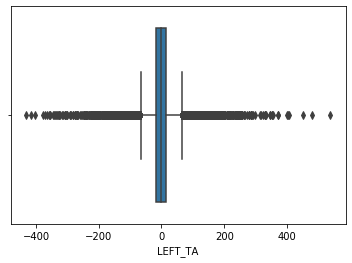

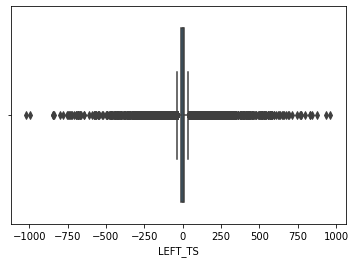

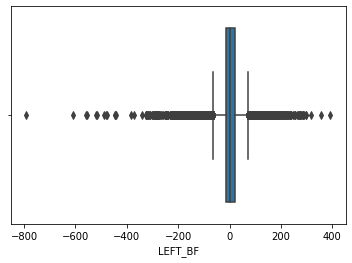

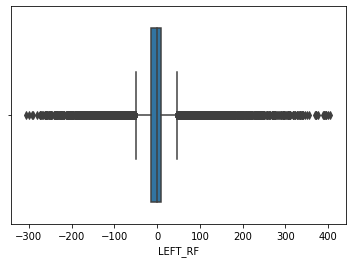

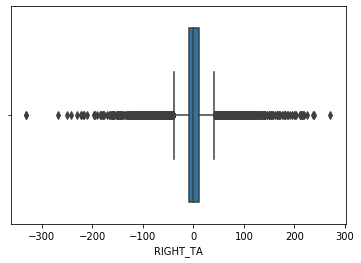

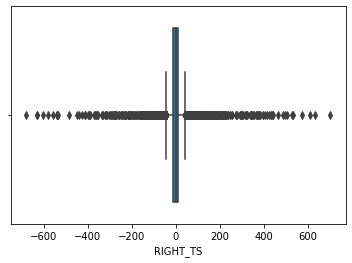

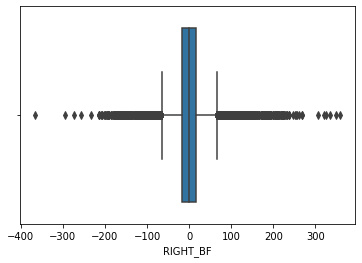

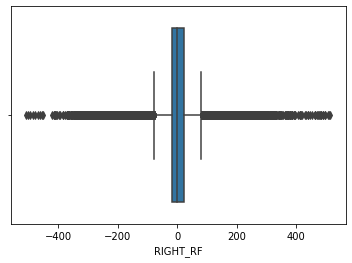

In [420]:
#sns.boxplot(np.clip(data.iloc[:,3],-300,300))
for i in range(8):
    plt.figure()
    sns.boxplot(data.iloc[:,3+i])
    #x_filter = signal.filtfilt(b, a, data.iloc[:,i+3])
    #x_filter = signal.filtfilt(b1, a1, x_filter)
    #ind = abs(zscore(x_filter))<10
    #sns.boxplot(x_filter[ind])

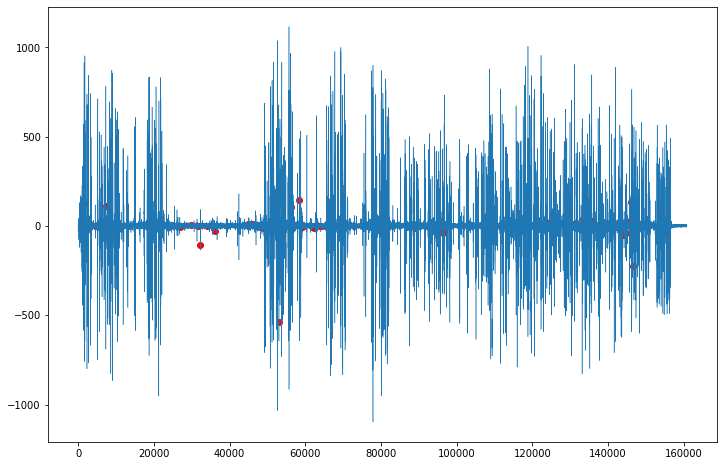

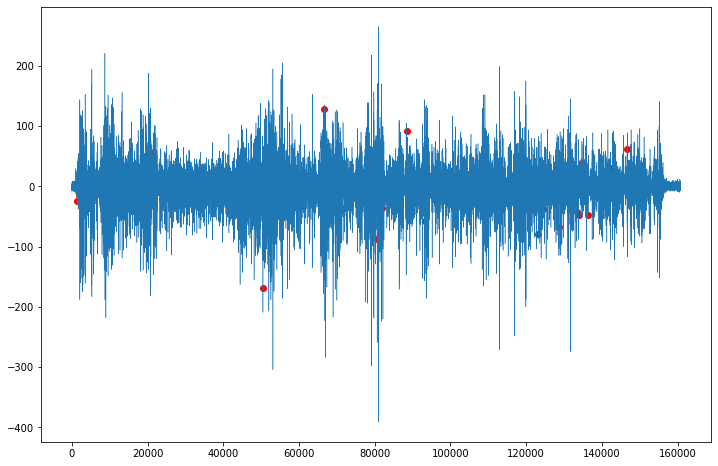

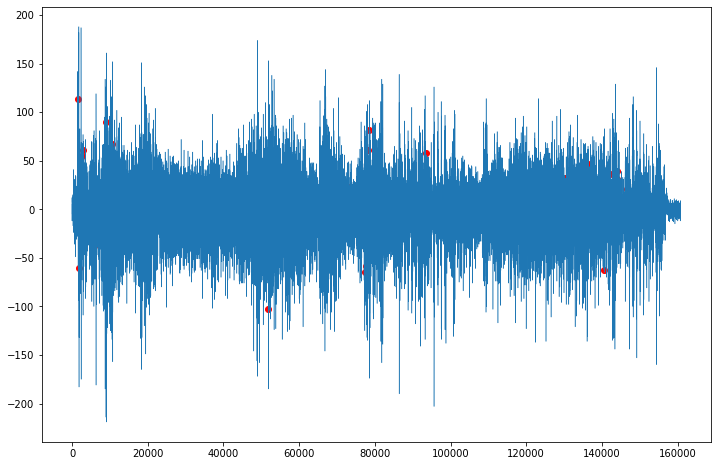

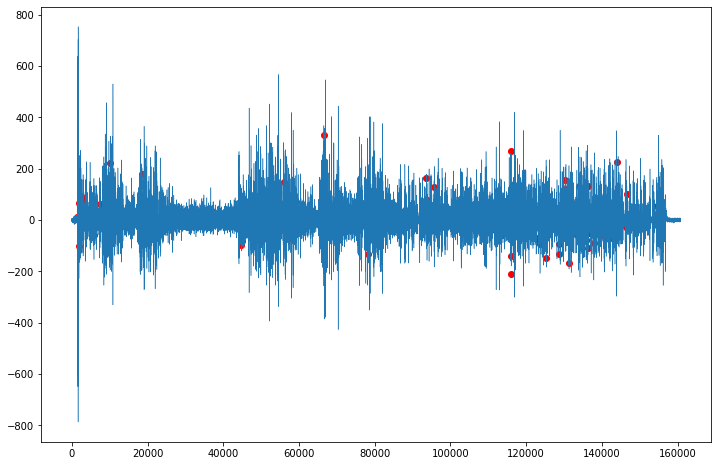

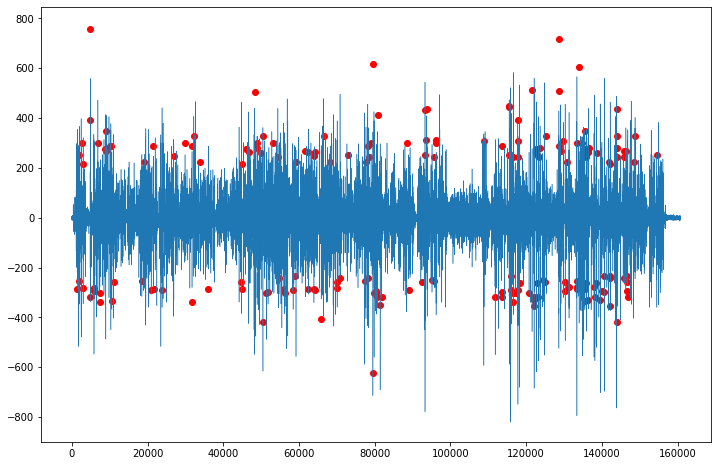

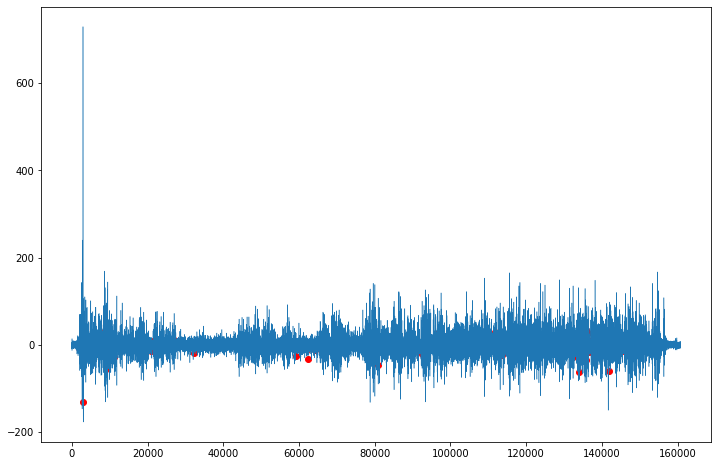

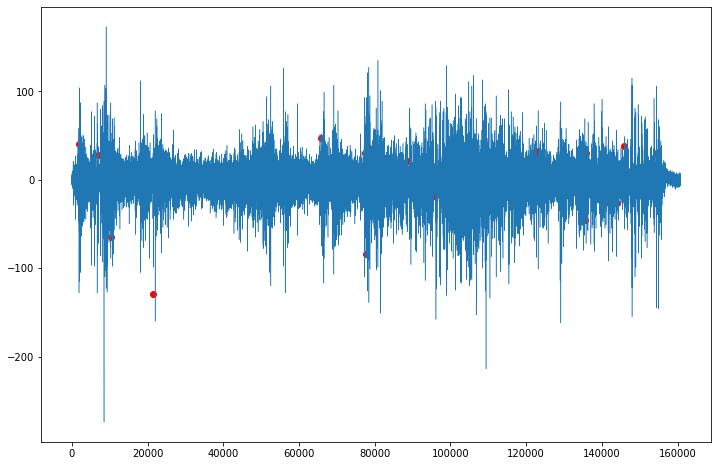

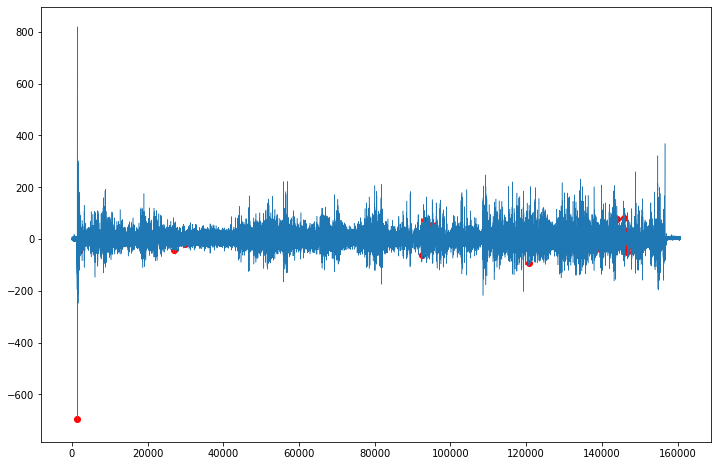

In [57]:
lof = LOF(n_neighbors=5,metric='minkowski')
ind = (lof.fit_predict(np.array(data.iloc[:,7])[:,np.newaxis]))==1

for i in range(8):
    #ind = abs(zscore(data.iloc[:,i+3]))<10
    #ind = (lof.fit_predict(np.array(data.iloc[:,i+3])[:,np.newaxis]))==1
    plt.figure(figsize=(12,8))
    data.loc[ind,data.columns[i+3]].plot(linewidth=0.5)
    #data.loc[~ind,'LEFT_TA'].plot(linewidth=0.5)
    plt.scatter(x=data.index[~ind],y=data.loc[~ind,data.columns[i+3]],color='r')
    #plt.xlim((215000,217000))

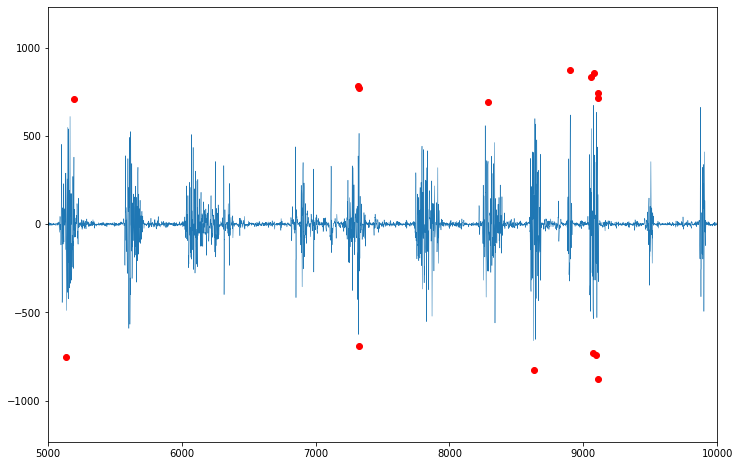

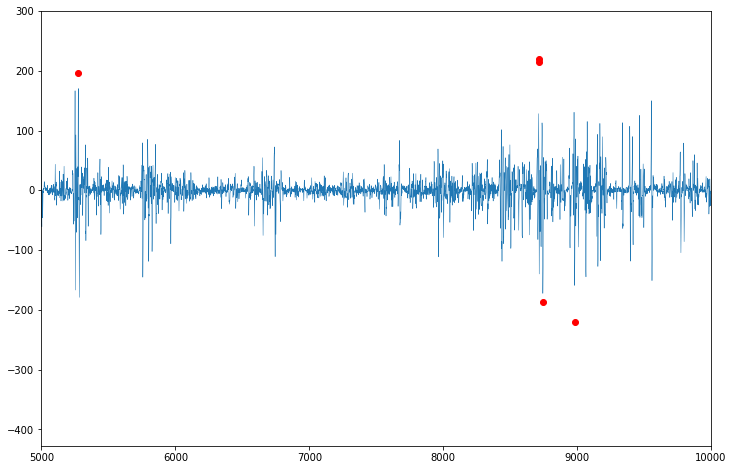

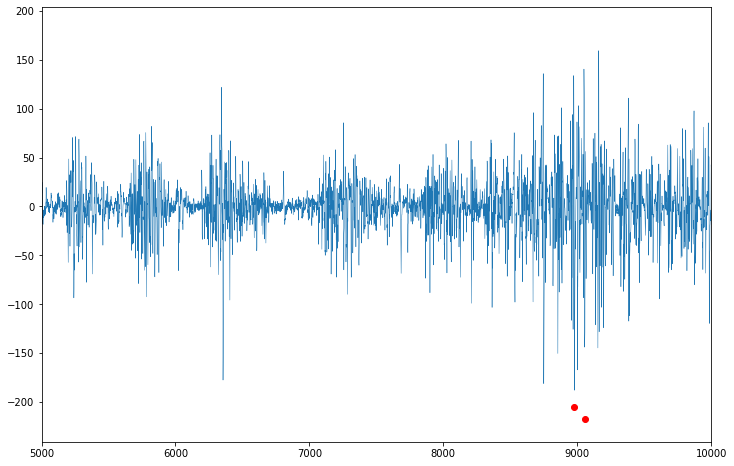

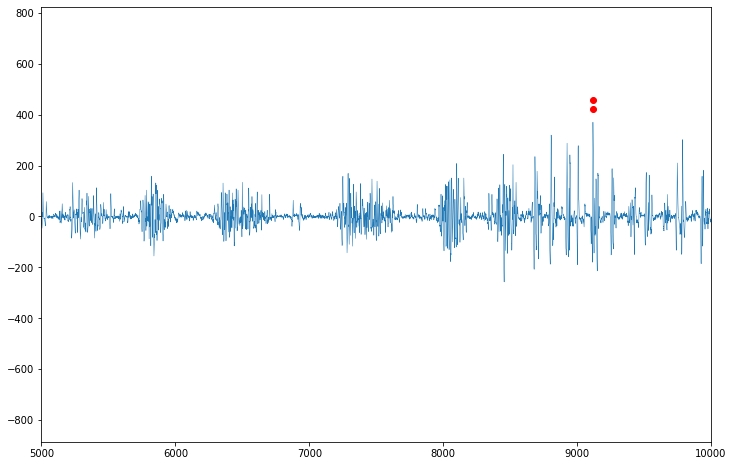

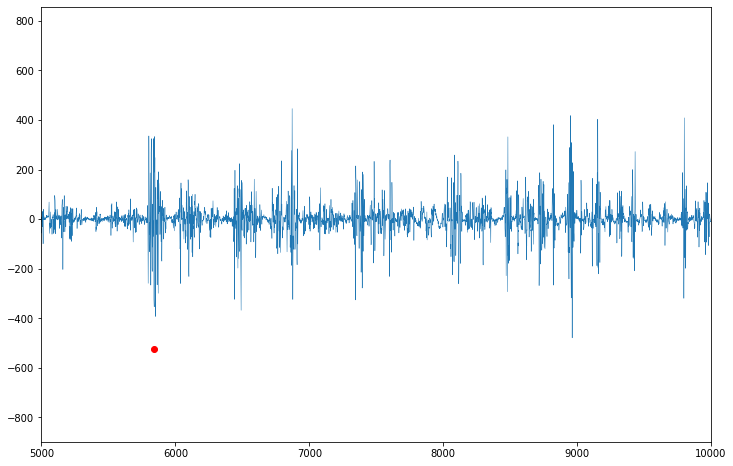

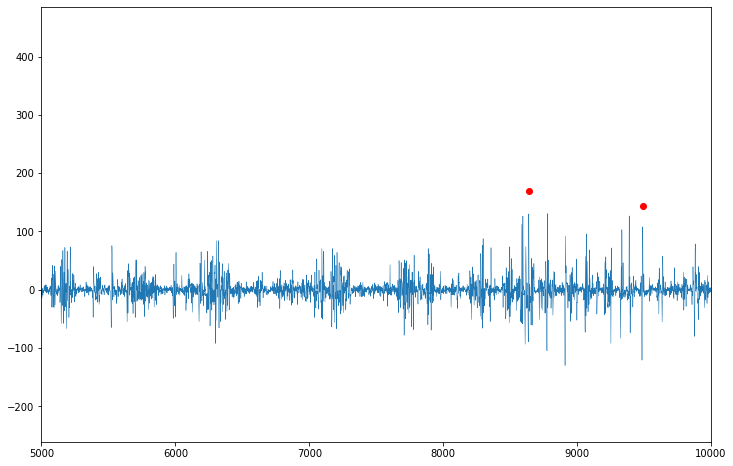

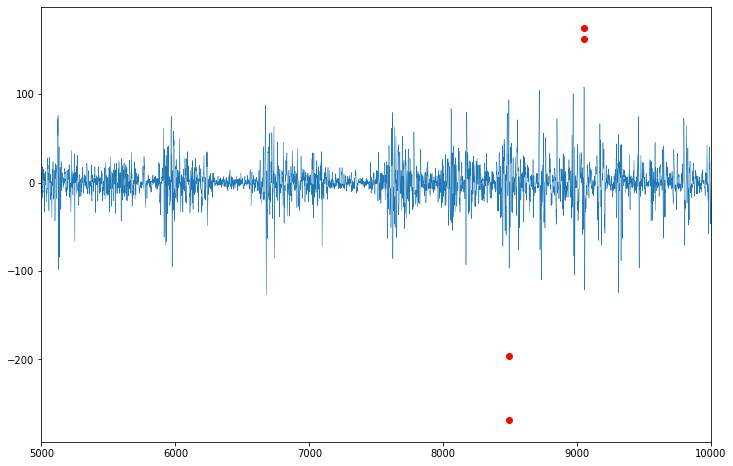

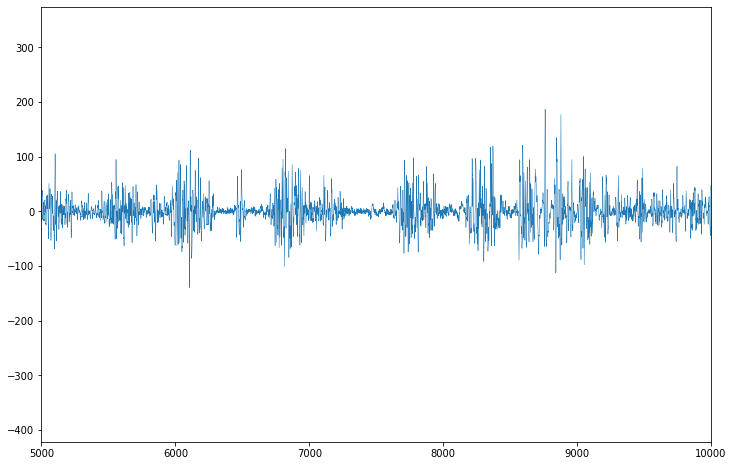

In [9]:
fs = 1000.0  # Sample frequency (Hz)
f0 = 50  # Frequency to be removed from signal (Hz)
Q = 100.0  # Quality factor
# Design notch filter
b1, a1 = signal.iirnotch(f0, Q, fs)
for i in range(8):
    x_filter = signal.filtfilt(b, a, data.iloc[:,i+3])
    #x_filter = signal.filtfilt(b1, a1, x_filter)
    plt.figure(figsize=(12,8))
    ind = abs(zscore(x_filter))<10
    #ind = (lof.fit_predict(x_filter[:,np.newaxis]))==1
    plt.plot(data.index[ind],x_filter[ind],linewidth=0.5)
    plt.scatter(data.index[~ind],x_filter[~ind],color='r')
    plt.xlim((5000,10000))
    #plt.ylim((-200,200))
    #x_filter[~ind]=x_filter[ind].mean()

In [128]:
ind=clf.fit_predict(np.array(data.iloc[:,7])[:,np.newaxis])

In [130]:
set(ind)

{-1, 1}

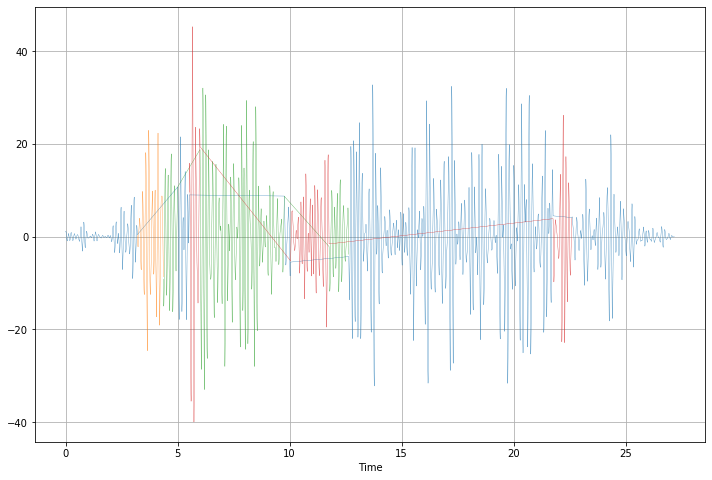

In [6]:
fs = 1000.0  # Sample frequency (Hz)
f0 = 9.5  # Frequency to be removed from signal (Hz)
Q = 100.0  # Quality factor
# Design notch filter
#b, a = signal.iirnotch(f0, Q, fs)
fn = 5
wn=2*fn/1000
fn1= 10
wn1=2*fn1/1000
b, a = signal.butter(4, [wn,wn1], 'bandpass')
temp = signal.filtfilt(b,a,data.iloc[:,5])
plt.figure(figsize=(12,8))
for j in set(data.Label2):
    ind = data.Label2 == j
    sns.lineplot(data.Time[ind],temp[ind],linewidth=0.3)
    #plt.ylim((-200,200))
    #plt.xlim((35,40))
    plt.grid(True)

5.246336609781101


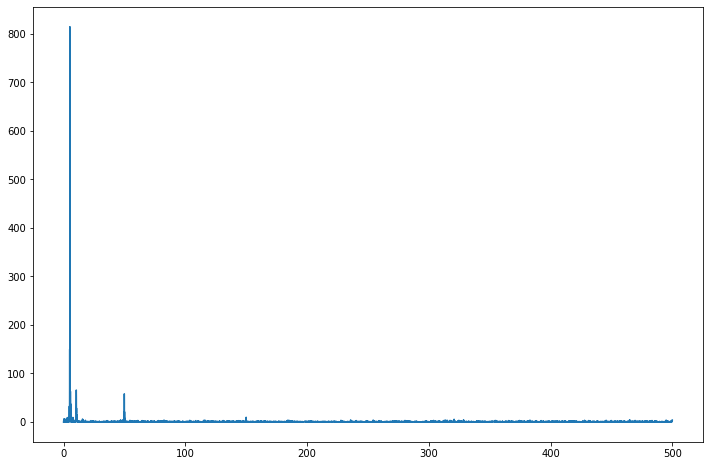

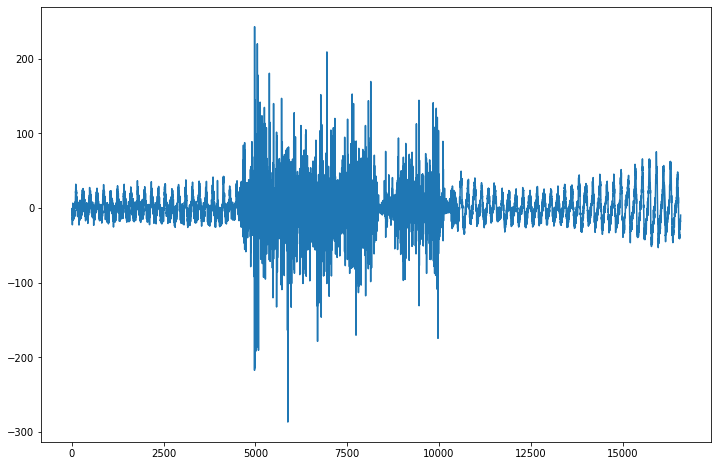

In [27]:
fs = 1000.0  # Sample frequency (Hz)
f0 = 4.58  # Frequency to be removed from signal (Hz)
Q = 100.0  # Quality factor
b, a = signal.iirnotch(f0, Q, fs)
temp = signal.filtfilt(b,a,data.iloc[:,2+7])
plt.figure(figsize=(12,8))
#freqs, power=signal.periodogram(np.clip(data.iloc[:,2+7],-200,200), 1e3)
freqs, power=signal.periodogram(temp, 1e3)
plt.plot(freqs,power)
plt.figure(figsize=(12,8))
#plt.plot((np.clip(data.iloc[:,2+7],-200,200)))
plt.plot(temp)
print(freqs[np.argmax(power)])

In [57]:
data.iloc[:,3:] = normalize(data.iloc[:,3:])

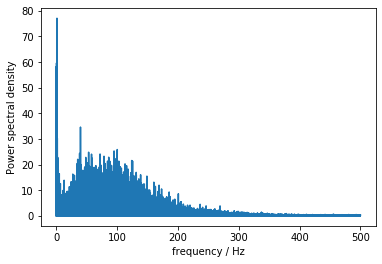

1.5213679004679426


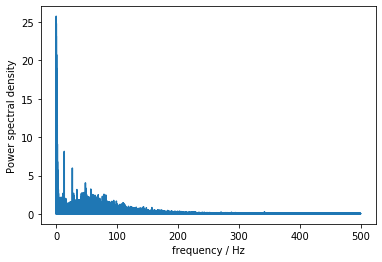

0.0798385487126034


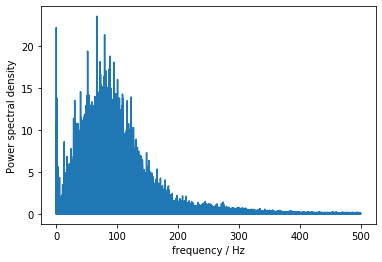

67.12204209265707


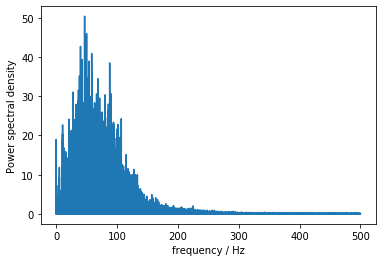

46.92288926836841


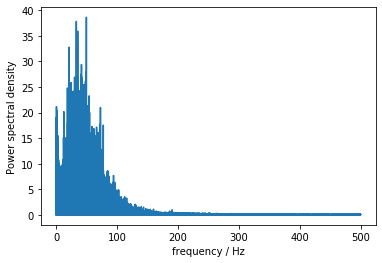

49.6418353995254


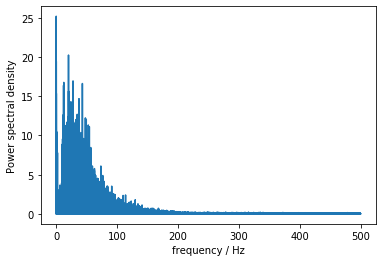

0.1064513982834712


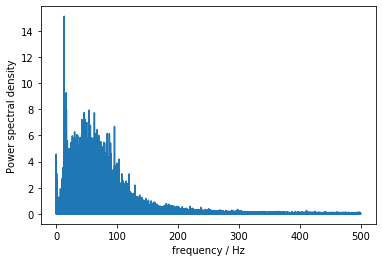

13.28424741079151


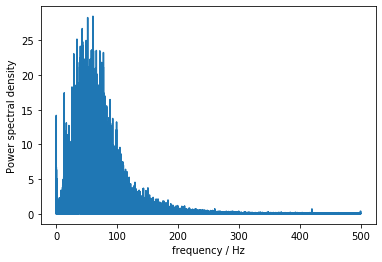

60.39786210108447


In [33]:
label = 2
label2 = 6
ind = (data.Label2 == label) & (data.Label1 == label)
ind2 = (data.Label2 == label2) & (data.Label1 == label2)
fn= 10
wn=2*fn/1000
b, a = signal.butter(4, wn, 'highpass')
fs = 1000.0  # Sample frequency (Hz)
f0 = 40  # Frequency to be removed from signal (Hz)
Q = 100.0  # Quality factor
# Design notch filter
b1, a1 = signal.iirnotch(f0, Q, fs)
b2, a2 = signal.iirnotch(81, Q, fs)
for i in np.arange(3,11):
    plt.figure()
    freqs, power=signal.periodogram(data.loc[:,data.columns[i]], 1e3)
    #freqs2, power2=signal.periodogram(data.loc[ind2,data.columns[i]], 1e3)
    #ind = (lof.fit_predict(np.array(data.iloc[:,i])[:,np.newaxis]))==1
    #data.loc[~ind,data.columns[i]]=data.loc[ind,data.columns[i]].mean()
    #freqs, power=signal.periodogram(data.iloc[:,i], 1e3)
    #x_filter = signal.filtfilt(b, a, data.loc[:,data.columns[i]])
    #x_filter = signal.filtfilt(b, a, data.loc[:,data.columns[i]])
    #x_filter = signal.filtfilt(b2, a2, x_filter)
    #ind = abs(zscore(x_filter))<10
    #ind = (lof.fit_predict(np.array(x_filter)[:,np.newaxis]))==1
    
    #x_filter[~ind]=np.mean(x_filter[ind])
    #freqs, power=signal.periodogram(x_filter, 1e3)
    plt.plot(freqs,power)
    #plt.plot(freqs2,power2,alpha=0.5)
    plt.xlabel('frequency / Hz')
    plt.ylabel('Power spectral density')
    plt.show()
    print(freqs[np.argmax(power)])

Text(0.5, 1.0, 'Unnormal')

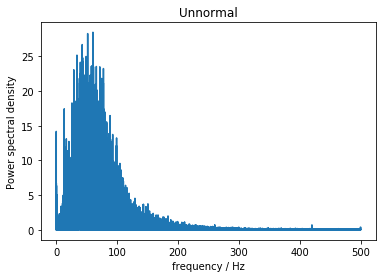

In [37]:
plt.figure()
freqs4, power4=signal.periodogram(data.loc[:,data.columns[10]], 1e3)
plt.plot(freqs4,power4)
#plt.plot(freqs2,power2,alpha=0.5)
plt.xlabel('frequency / Hz')
plt.ylabel('Power spectral density')
plt.title('Unnormal')
# plt.savefig('./pic/unnormal_fre2.svg', format="svg",bbox_inches='tight')
#print(freqs[np.argmax(power)])

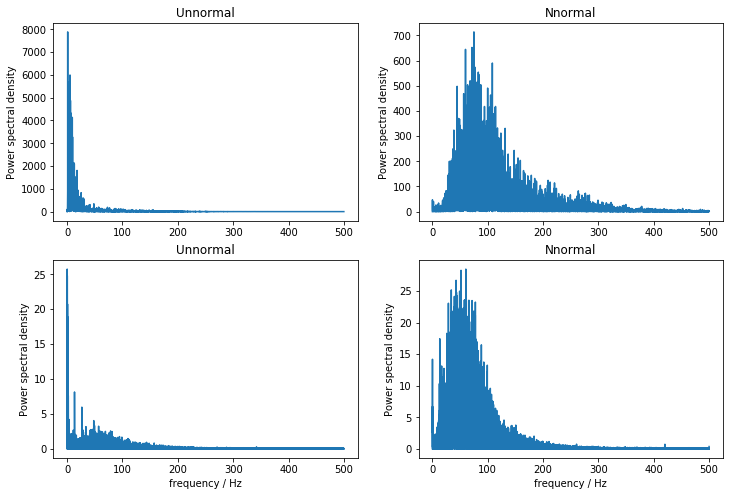

In [47]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(freqs1,power1)
#plt.plot(freqs2,power2,alpha=0.5)
# plt.xlabel('frequency / Hz')
plt.ylabel('Power spectral density')
plt.title('Unnormal')

plt.subplot(2,2,2)
plt.plot(freqs2,power2)
#plt.plot(freqs2,power2,alpha=0.5)
# plt.xlabel('frequency / Hz')
plt.ylabel('Power spectral density')
plt.title('Nnormal')

plt.subplot(2,2,3)
plt.plot(freqs3,power3)
#plt.plot(freqs2,power2,alpha=0.5)
plt.xlabel('frequency / Hz')
plt.ylabel('Power spectral density')
plt.title('Unnormal')

plt.subplot(2,2,4)
plt.plot(freqs4,power4)
#plt.plot(freqs2,power2,alpha=0.5)
plt.xlabel('frequency / Hz')
plt.ylabel('Power spectral density')
plt.title('Nnormal')

plt.savefig('./pic/unnormal_fre.svg', format="svg",bbox_inches='tight')

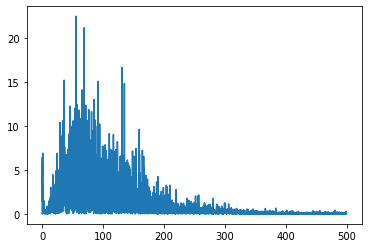

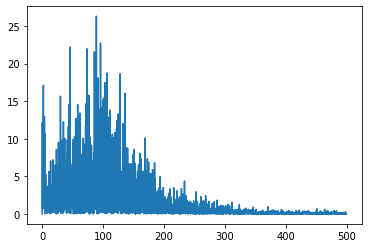

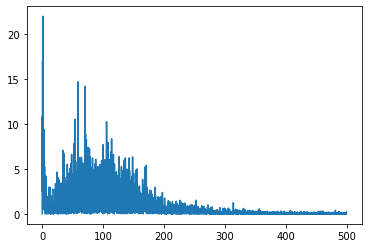

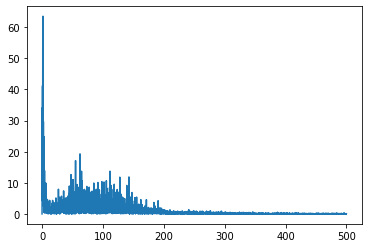

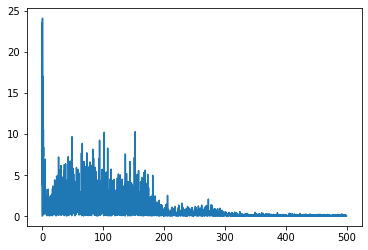

In [11]:
label = 1
ind = (data.Label2 == label) & (data.Label1 == label)
x_filter = signal.filtfilt(b1, a1, data.loc[ind,data.columns[3+0]])
#x_filter = signal.filtfilt(b1, a1, x_filter)
#ind = abs(zscore(x_filter))<10
#x_filter[~ind]=np.median(x_filter[ind])
l = len(x_filter)
N = 5
for i in range(N):
    freqs, power=signal.periodogram(x_filter[i*l//N:(i+1)*l//N], 1e3)
    plt.figure()
    plt.plot(freqs,power)
    #plt.plot([30,30],[0,10])

In [113]:
l//20

1928

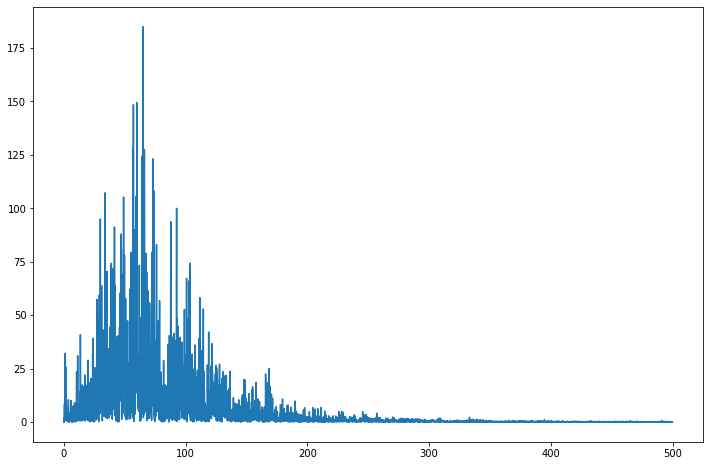

In [87]:
label = 0
ind = (data.Label1==label) & (data.Label2==label)
data2 = data[ind]
l=len(data2)
#sc = StandardScaler()
k = 3+0
N = 1
fn= 5
wn=2*fn/1000
#b, a = signal.butter(4, wn, 'highpass')

fs = 1000.0  # Sample frequency (Hz)
f0 = 75  # Frequency to be removed from signal (Hz)
Q = 100.0  # Quality factor
# Design notch filter
b1, a1 = signal.iirnotch(f0, Q, fs)

for i in range(N):
    plt.figure(figsize=(12,8))
    #plt.subplot(2,1,1)
    #data.iloc[i*10000:(i+1)*10000,7].plot(linewidth=0.5)
    temp = np.array(data2.iloc[i*l//(3*N):(i+1)*l//(3*N),k])
    #temp = np.clip(data.iloc[i*l/5:(i+1)*l/5,7],-500,500)
    #plt.plot(sc.fit_transform(temp)[:,0])
    #plt.plot(temp)
    #plt.subplot(2,1,2)
    #x_filter = signal.filtfilt(b, a, data.iloc[:,k])
    #x_filter = signal.filtfilt(b1, a1, x_filter)
    #ind = abs(zscore(x_filter))<5
    #x_filter[~ind]=np.mean(x_filter[ind])
    #temp = np.array(x_filter[i*l//N:(i+1)*l//N])
    #plt.plot(signal.filtfilt(b, a, temp))
    #plt.ylim((-500,500))
    #plt.plot(temp)
    freqs, power=signal.periodogram(temp, 1e3)
    plt.plot(freqs,power)
#for i in range(N,N+15):
#    plt.figure(figsize=(12,8))
    #plt.subplot(2,1,1)
    #data.iloc[i*10000:(i+1)*10000,7].plot(linewidth=0.5)
#    temp = np.array(data2.iloc[i*l//(3*N):(i+1)*l//(3*N),k])
    #temp = np.clip(data.iloc[i*l/5:(i+1)*l/5,7],-500,500)
    #plt.plot(sc.fit_transform(temp)[:,0])
#    plt.plot(temp)
#    freqs, power=signal.periodogram(temp, 1e3)
    #plt.plot(freqs,power)
#for i in range(N+15,N+30):
#    plt.figure(figsize=(12,8))
    #plt.subplot(2,1,1)
    #data.iloc[i*10000:(i+1)*10000,7].plot(linewidth=0.5)
#    temp = np.array(data2.iloc[i*l//(3*N):(i+1)*l//(3*N),k])
    #temp = np.clip(data.iloc[i*l/5:(i+1)*l/5,7],-500,500)
    #plt.plot(sc.fit_transform(temp)[:,0])
#    plt.plot(temp)
#    freqs, power=signal.periodogram(temp, 1e3)
    #plt.plot(freqs,power)

In [24]:
ind_temp=(data.index[ind][1:]-data.index[ind][:-1])>1
data.index[ind][:-1][ind_temp]

Int64Index([73279, 79495, 79503, 79513, 79523, 79533, 79543, 79553, 79563,
            79573, 79583, 79593, 79603, 79713, 79775, 79783, 79793, 80359],
           dtype='int64')

In [46]:
np.isnan(np.min(np.array(emg_data.iloc[9350:9360,3:])))

True

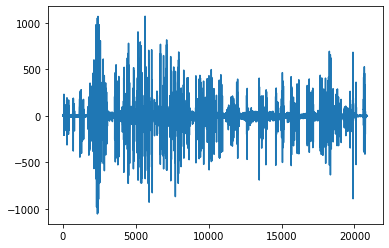

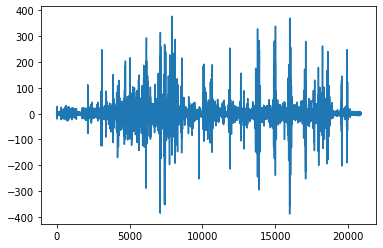

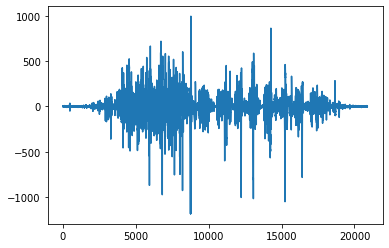

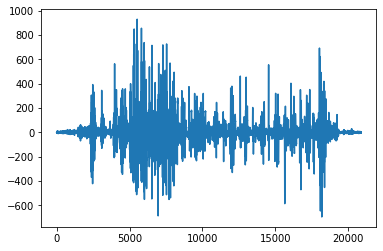

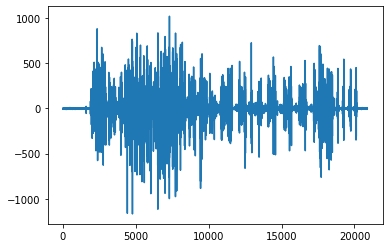

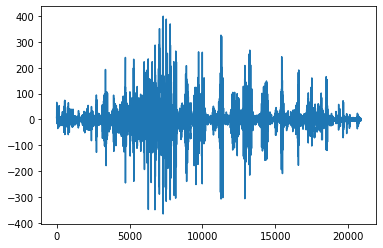

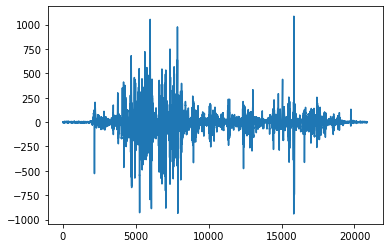

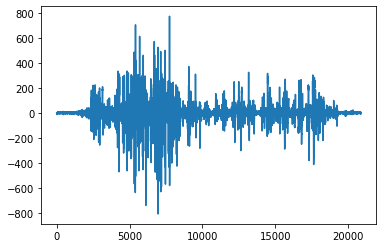

In [163]:
#temp = sc.fit_transform(data.iloc[:,3:])
for i in np.arange(3,11):
    plt.figure()
    #freqs, power=signal.periodogram(signal.filtfilt(b, a, np.clip(data.loc[:,data.columns[i]],-500,500)), 1e3)
    #freqs, power=signal.periodogram(data.iloc[:,i], 1e3)
    x_filter = signal.filtfilt(b, a, data.loc[:,data.columns[i]])
    #x_filter = signal.filtfilt(b1, a1, x_filter)
    ind = abs(zscore(x_filter))<10
    x_filter[~ind]=np.median(x_filter[ind])
    #x_filter = sc.fit_transform(x_filter[:,np.newaxis])
    plt.plot(x_filter)

    plt.show()

In [66]:
set(data.Label2)
'%f'%freqs[ind2]

'61.230260'

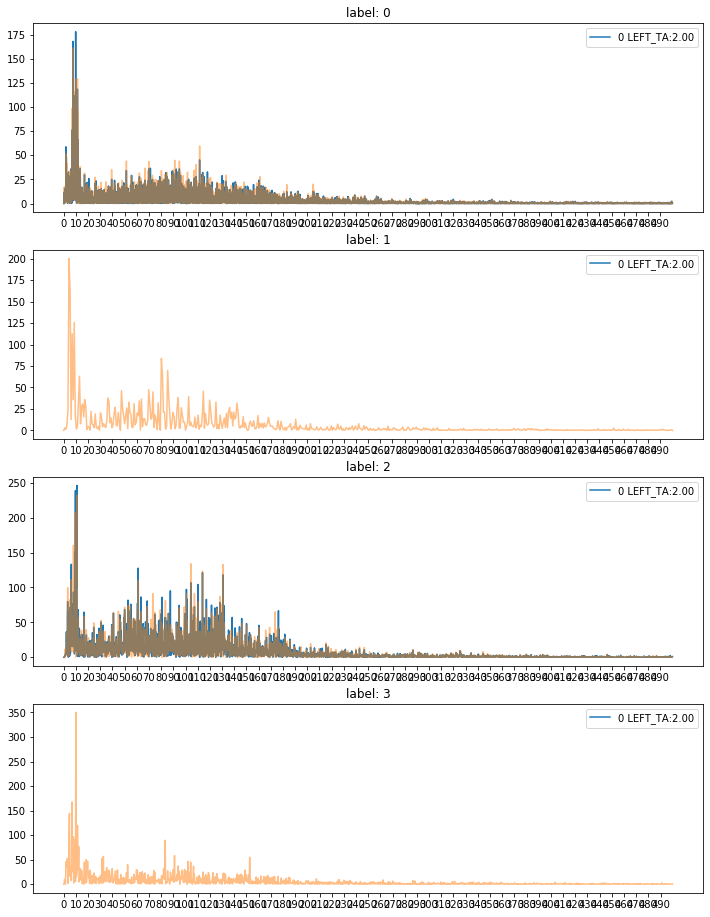

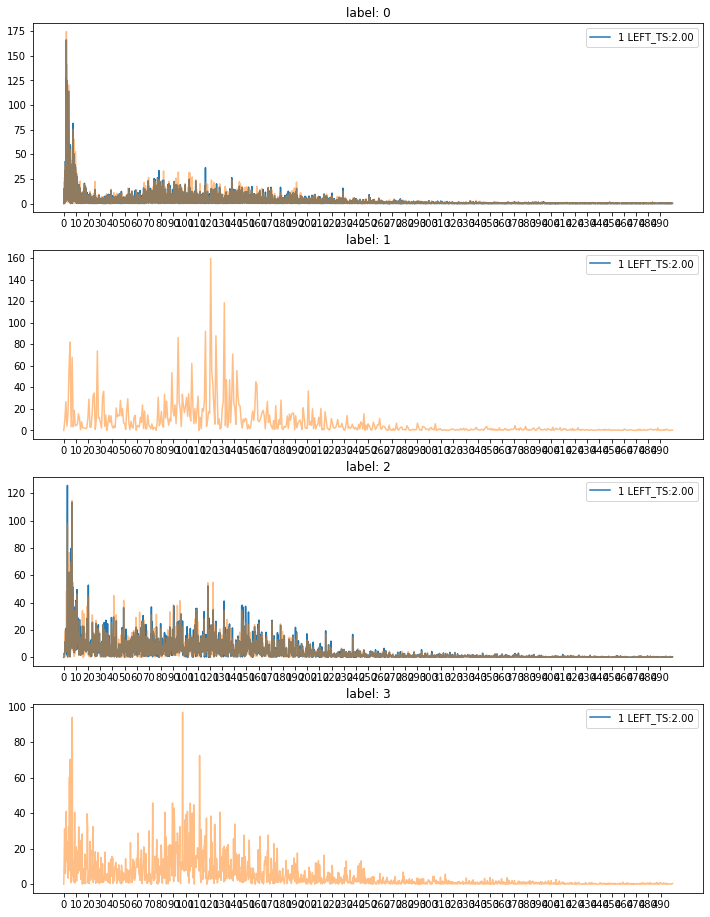

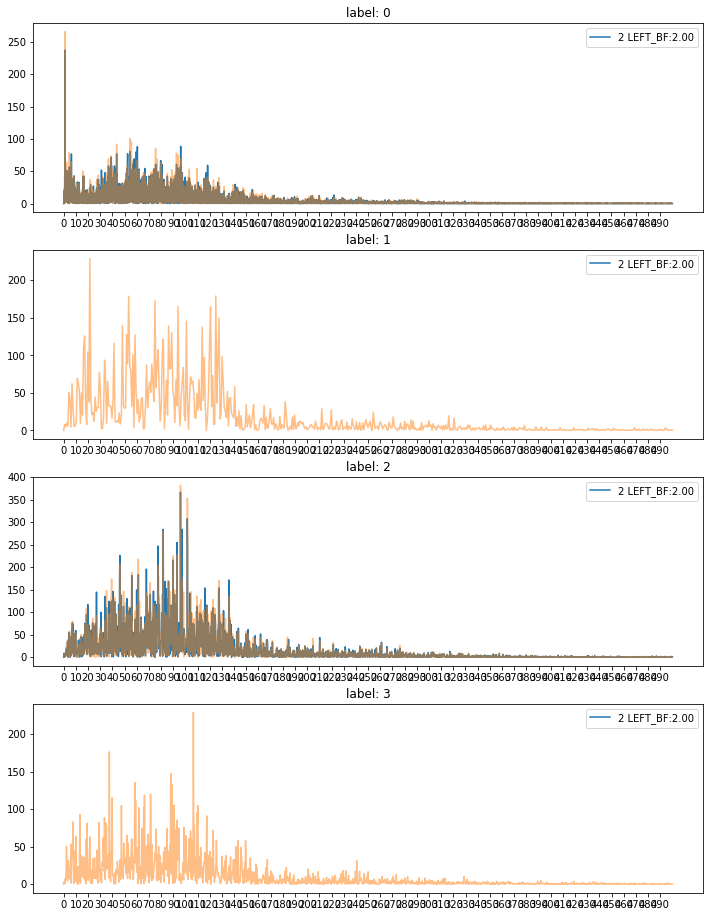

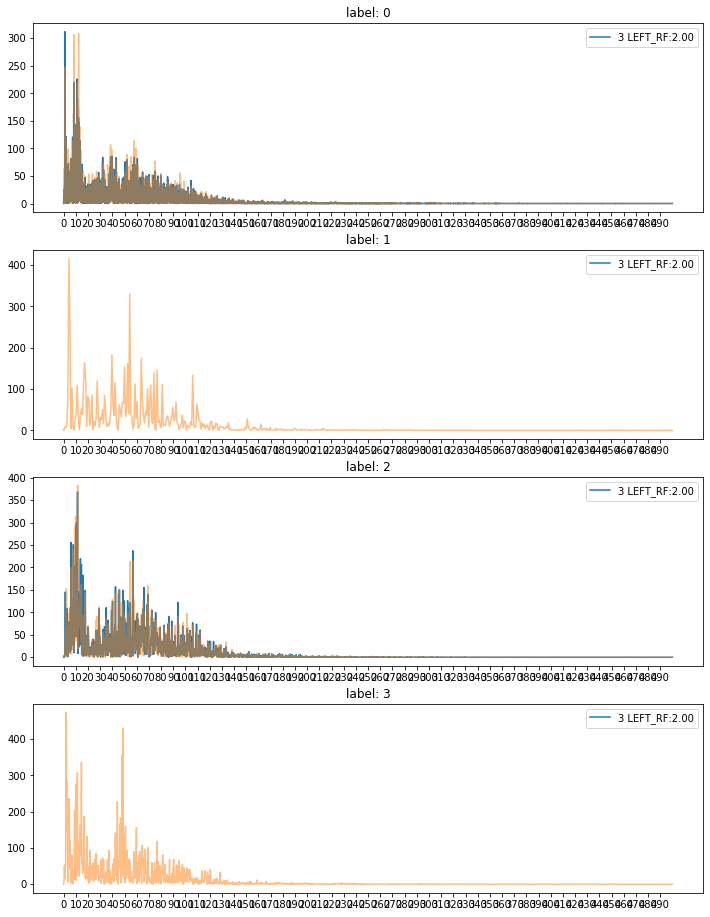

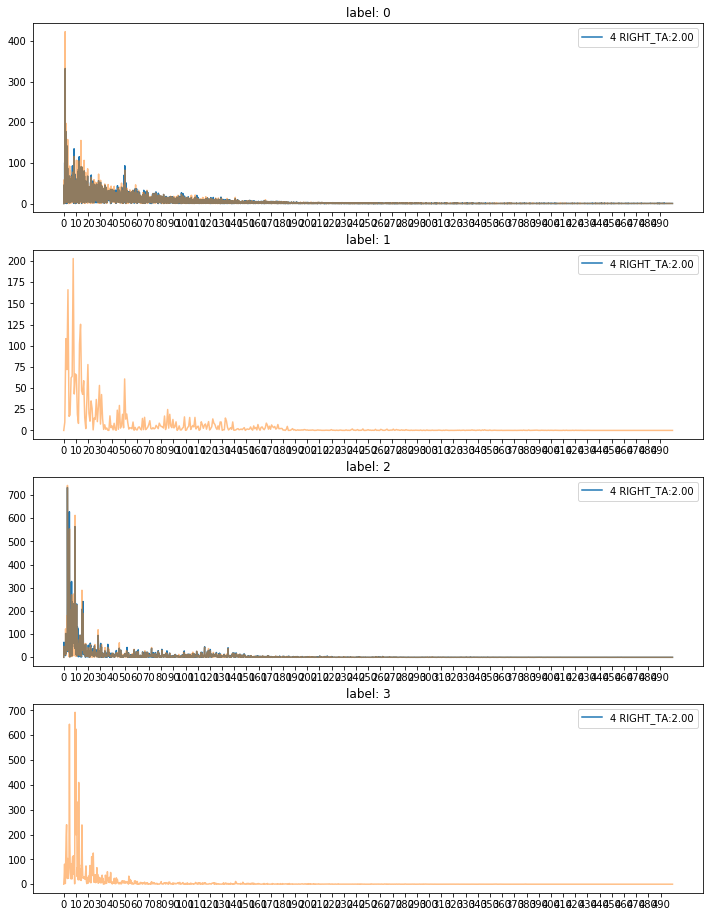

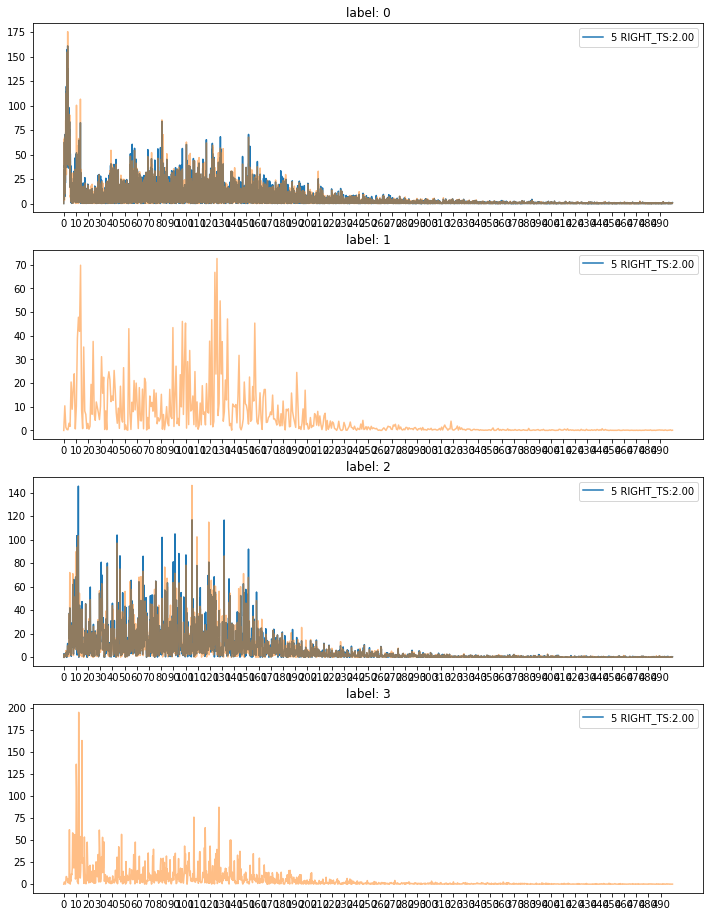

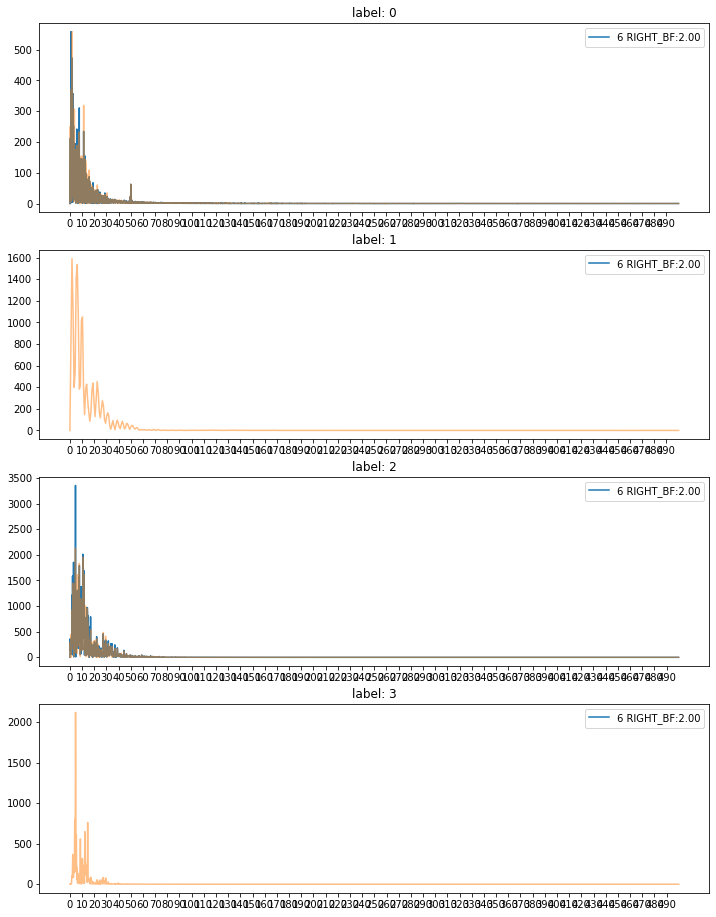

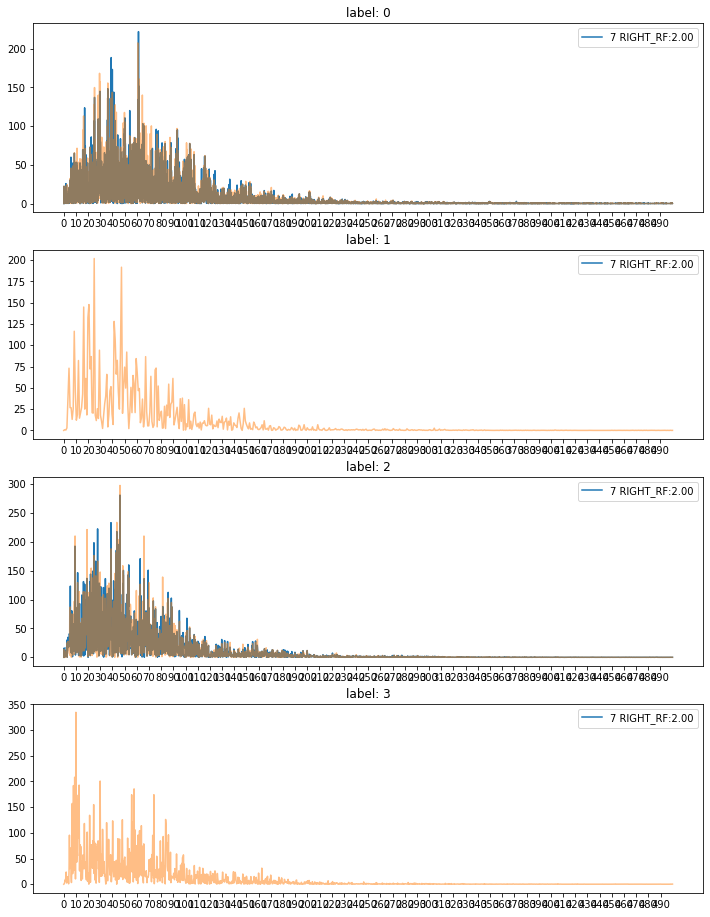

In [18]:
for i in range(8):
    plt.figure(figsize=(12,16))
    plt.title(data.columns[i+3])
    lab = 0
    for j in set(data.Label2):
        lab+=1
        ind = (data.Label2 == j) & (data.Label1 == j)
        ind3 = data.Label2 == j
        freqs,power = signal.periodogram(data.loc[ind,data.columns[3+i]],1e3)
        freqs2,power2 = signal.periodogram(data.loc[ind3,data.columns[3+i]],1e3)
        #ind2 = np.argmax(power)
        
        plt.subplot(4,1,lab)
        
        plt.title('label: %d'%j)
        plt.plot(freqs,power)
        plt.plot(freqs2,power2,alpha=0.5)
        plt.xticks(np.arange(0,500,10))
        #plt.xlim((0,250))
        plt.legend(labels=('%d %s:%0.2f'%(i,data.columns[i+3],2),))

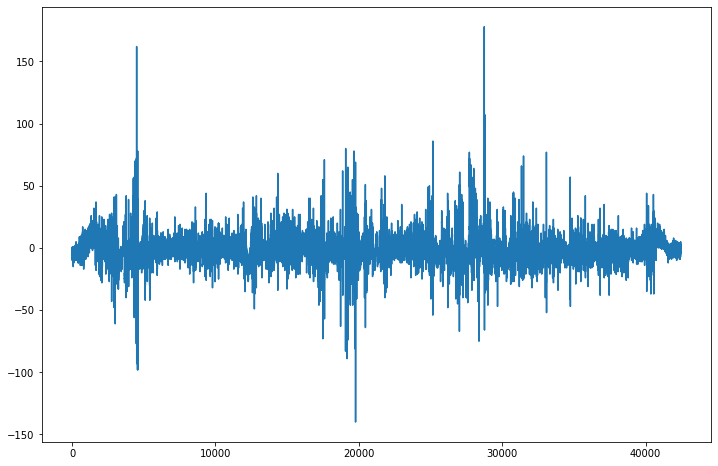

In [261]:
ind = data.Label2 == 0
a = np.array(data.index[ind])
np.where(a[1:]-a[:-1]>1)
plt.figure(figsize=(12,8))
#data.loc[ind,'LEFT_TS'].plot()
plt.plot(np.array(data.loc[ind,'LEFT_TS']))
#a[5589]

(0, 250)

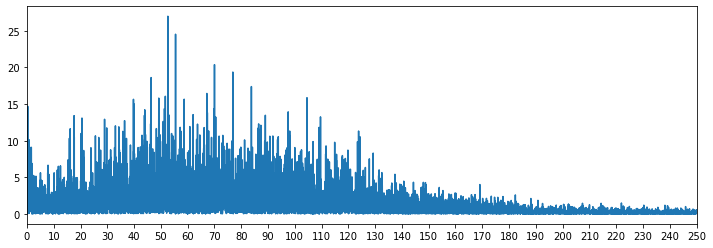

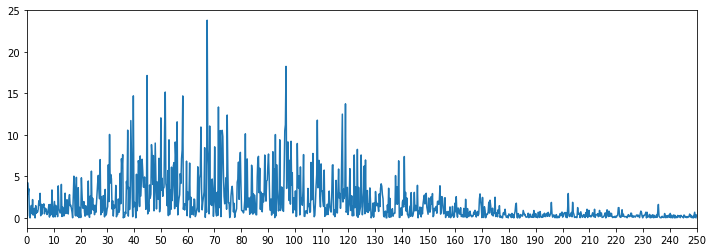

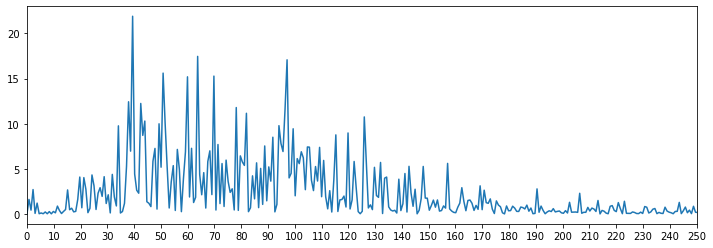

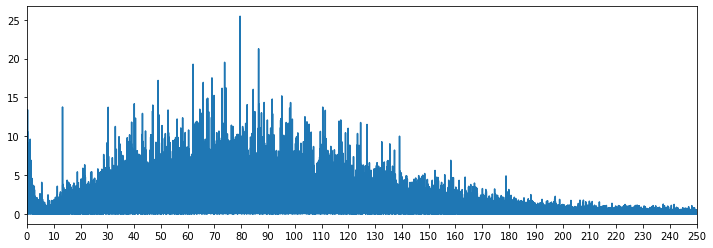

In [255]:
ind = data.Label2 == 0
a = np.array(data.index[ind])
plt.figure(figsize=(12,4))
#data.loc[ind,'LEFT_BF'].plot()
freqs,power = signal.periodogram(data.loc[ind,'LEFT_BF'],1e3)
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,10))
plt.xlim((0,250))

plt.figure(figsize=(12,4))
freqs,power = signal.periodogram(data.iloc[:4280,2+3],1e3)
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,10))
plt.xlim((0,250))

plt.figure(figsize=(12,4))
freqs,power = signal.periodogram(data.iloc[9681:10999,2+3],1e3)
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,10))
plt.xlim((0,250))

plt.figure(figsize=(12,4))
freqs,power = signal.periodogram(data.iloc[15951:,2+3],1e3)
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,10))
plt.xlim((0,250))

In [154]:
data.iloc[15952,2]

0

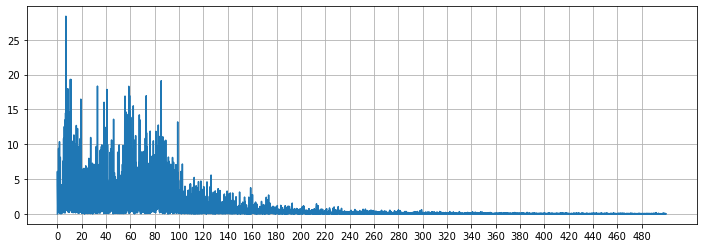

In [162]:
a = np.array(data.iloc[:4280,2+3])
b = np.array(data.iloc[9681:10999,2+3])
c = np.array(data.iloc[15951:,2+3])
d = np.concatenate([c])
freqs,power = signal.periodogram(d,1e3)
plt.figure(figsize=(12,4))
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,20))
plt.grid(True)
#plt.xlim((0,250))
plt.savefig('./test.jpg')

In [194]:
df.columns

Index(['G04_FoG_trial_1_emg.csv', 'G04_FoG_trial_2_emg.csv',
       'G06_FoG_trial_1_emg.csv', 'G06_FoG_trial_2_emg.csv',
       'G06_FoG_trial_3_emg.csv', 'G07_Freezing_Trial1_trial_1_emg.csv',
       'G08_FoG_1_trial_1_emg.csv', 'G08_FoG_2_trial_1_emg.csv',
       'G11_FoG_trial_1_emg.csv', 'G11_FoG_trial_2_emg.csv',
       'P379_M050_2_OFF_A_FoG_trial_1_emg.csv',
       'P379_M050_2_OFF_A_FoG_trial_2_emg.csv',
       'P379_M050_2_OFF_A_FoG_trial_3_emg.csv',
       'P379_M050_2_OFF_B_FoG_trial_1_emg.csv',
       'P379_M050_2_OFF_B_FoG_trial_2_emg.csv',
       'P379_M050_2_OFF_B_FoG_trial_3_emg.csv',
       'P551_M050_2_A_FoG_trial_1_emg.csv',
       'P551_M050_2_B_FoG_trial_1_emg.csv',
       'P551_M050_2_B_FoG_trial_2_emg.csv',
       'P812_M050_2_B_FoG_trial_1_emg.csv',
       'P812_M050_2_B_FoG_trial_2_emg.csv'],
      dtype='object')

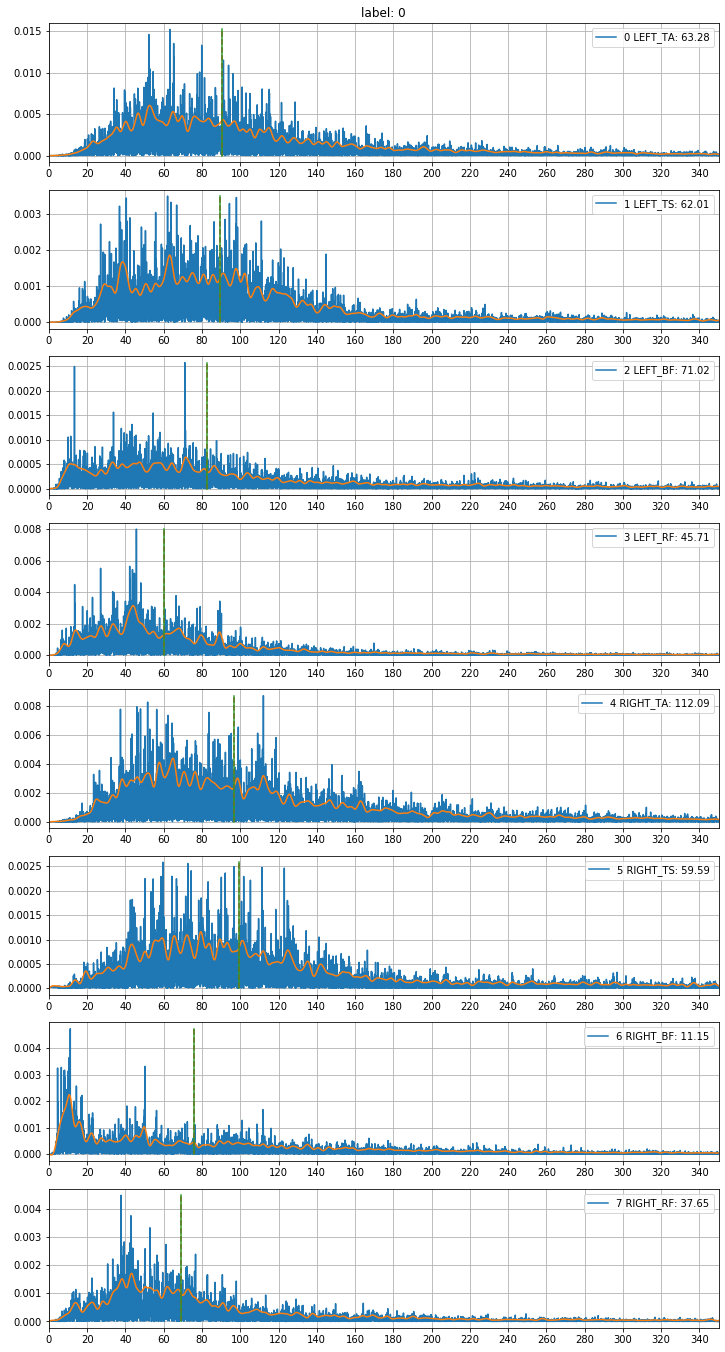

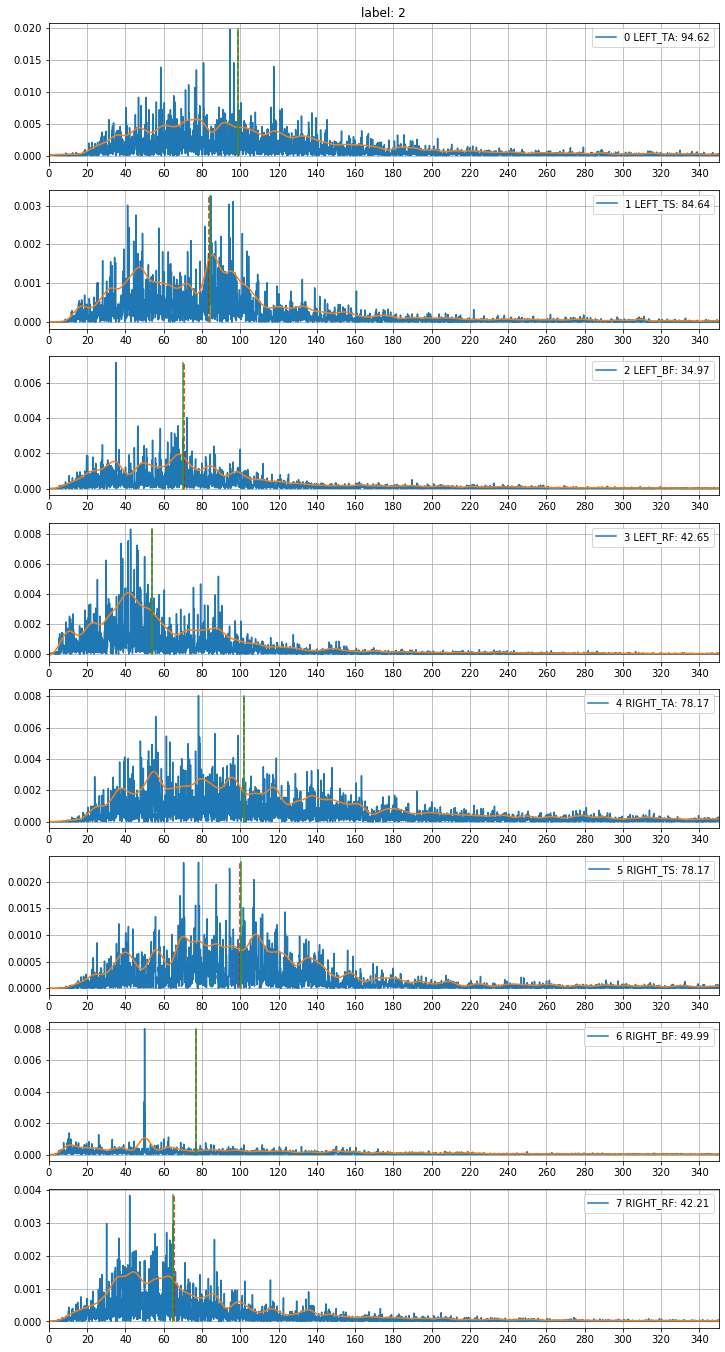

In [23]:
fn = 10
wn=2*fn/1000
b, a = signal.butter(4, wn, 'lowpass')
b1, a1 = signal.butter(1, wn, 'highpass')
length = len(df.columns)
for fi in np.arange(2,3):
    data = pd.read_csv('./data/'+df.columns[3])
    data = data.fillna({'LEFT_TA':data.LEFT_TA.mean(),
                           'LEFT_TS':data.LEFT_TS.mean(),
                           'LEFT_BF':data.LEFT_BF.mean(),
                           'LEFT_RF':data.LEFT_RF.mean(),
                           'RIGHT_TA':data.RIGHT_TA.mean(),
                           'RIGHT_TS':data.RIGHT_TS.mean(),
                           'RIGHT_BF':data.RIGHT_BF.mean(),
                           'RIGHT_RF':data.RIGHT_RF.mean()})
    #data = data.dropna().reset_index(drop=True)
    data.iloc[:,3:] = normalize(data.iloc[:,3:])
    for i in set(data.Label2):
        plt.figure(figsize=(12,24))
        #plt.title(data.columns[i+3])
        ind = data.Label2 == i
        plt.title('label: %d'%i)
        for j in range(8):

            freqs,power = signal.periodogram(signal.filtfilt(b1,a1,data.loc[ind,data.columns[3+j]]),1e3)            
            
            ind2 = np.argmax(power)
            power_filt = signal.filtfilt(b, a, power)*2
            
            total = cumtrapz(power_filt,freqs)
            w=np.where(total>=(total[-1]/2))[0][0]
            
            total2 = cumtrapz(power,freqs)
            w2=np.where(total2>=(total2[-1]/2))[0][0]            
            
            plt.subplot(8,1,j+1)
            if j == 0:
                plt.title('label: %d'%i)
            plt.plot(freqs,power)
            plt.plot(freqs,power_filt)
            plt.plot([freqs[w],freqs[w]],[0,power.max()],linestyle='--',color='r')
            plt.plot([freqs[w2],freqs[w2]],[0,power.max()],linestyle='-')
            plt.xticks(np.arange(0,500,20))
            plt.xlim((0,350))
            plt.grid(True)
            plt.legend(labels=('%d %s: %0.2f'%(j,data.columns[j+3],freqs[ind2]),))
        #plt.savefig('./pic/label_%d/'%i+df.columns[fi].split('.')[0]+'.jpg')
        #plt.close()

In [207]:
fn = 30
wn=2*fn/1000
b, a = signal.butter(4, wn, 'lowpass')
#x_filter = signal.filtfilt(b, a, x[1,:,1])

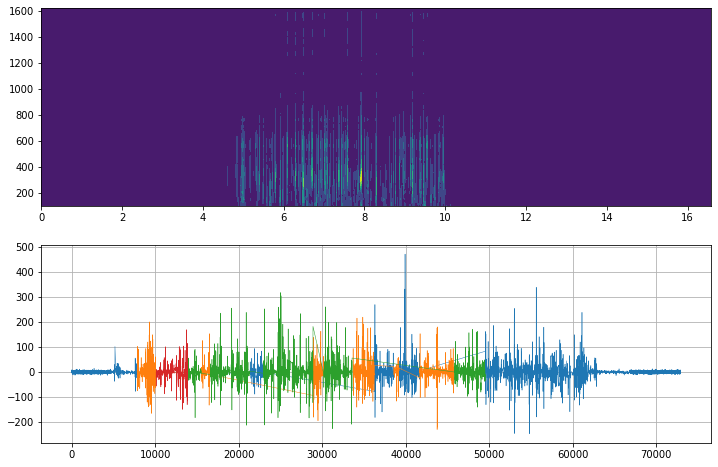

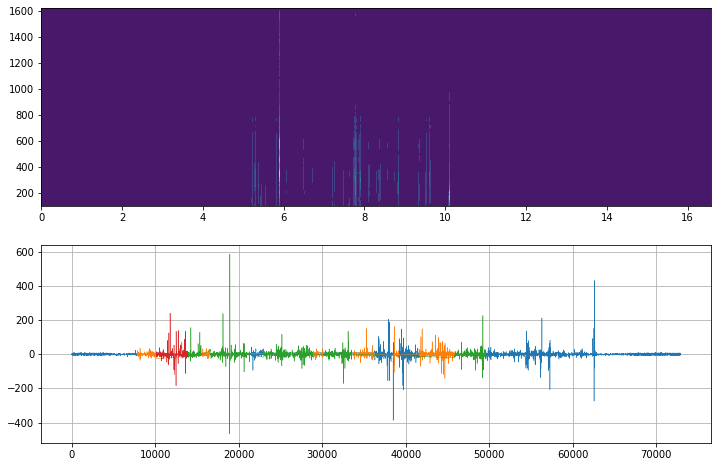

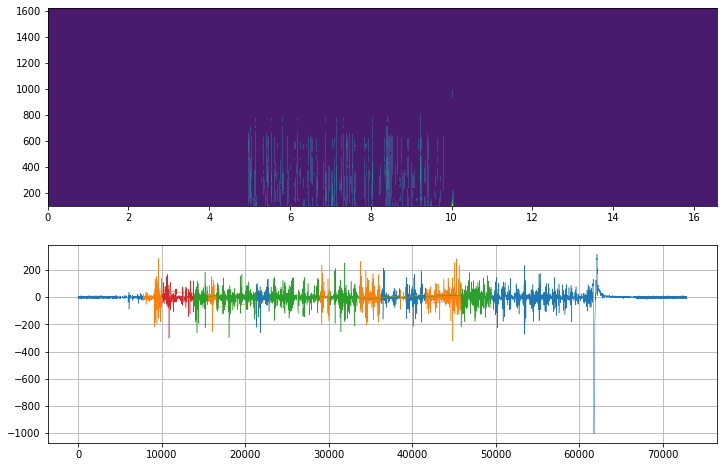

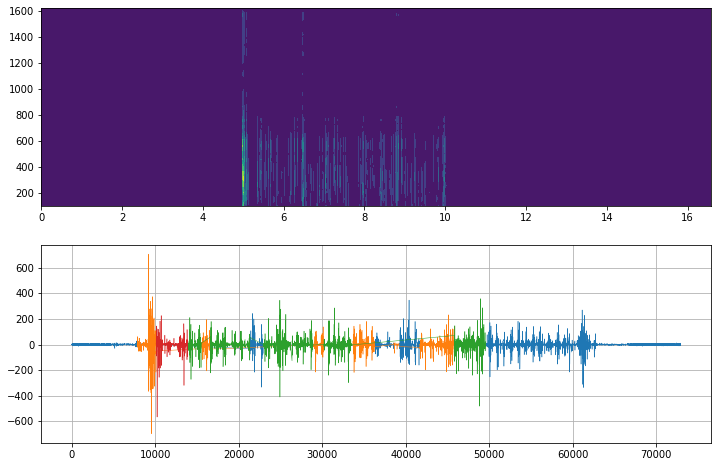

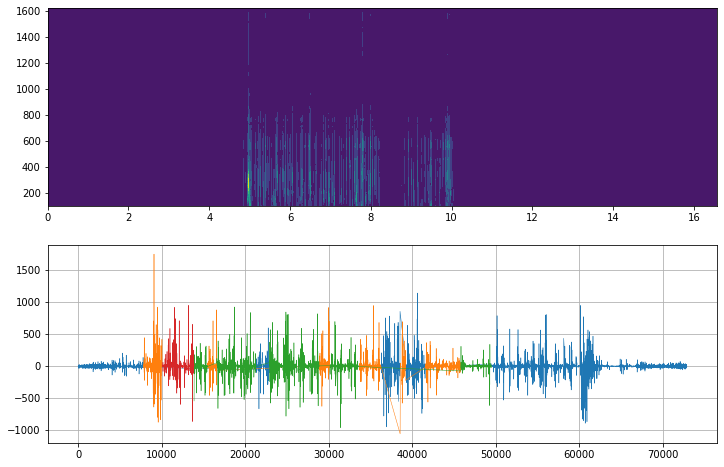

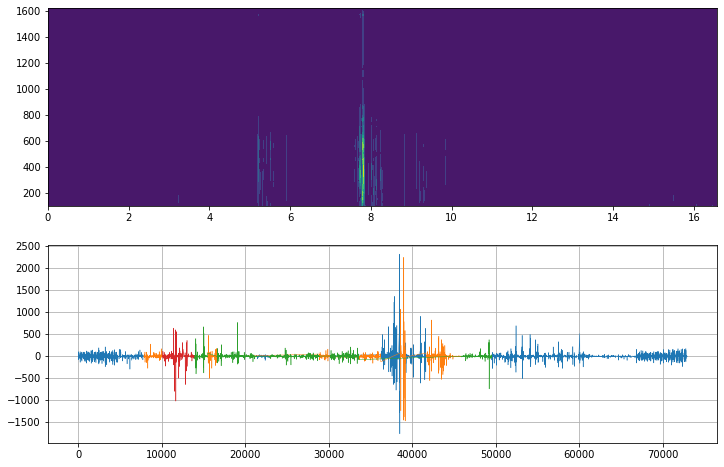

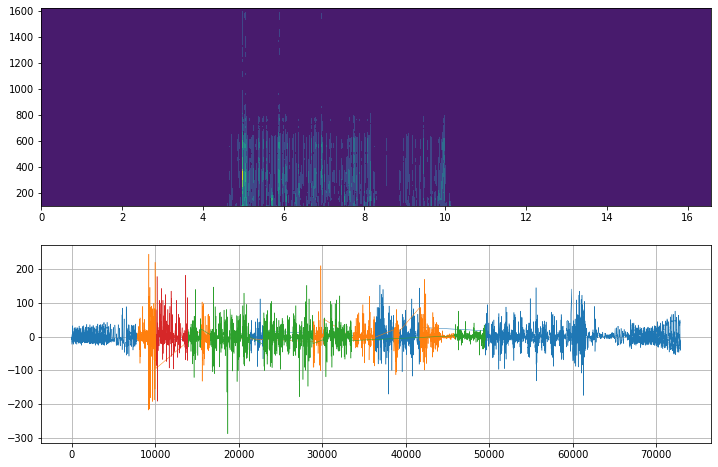

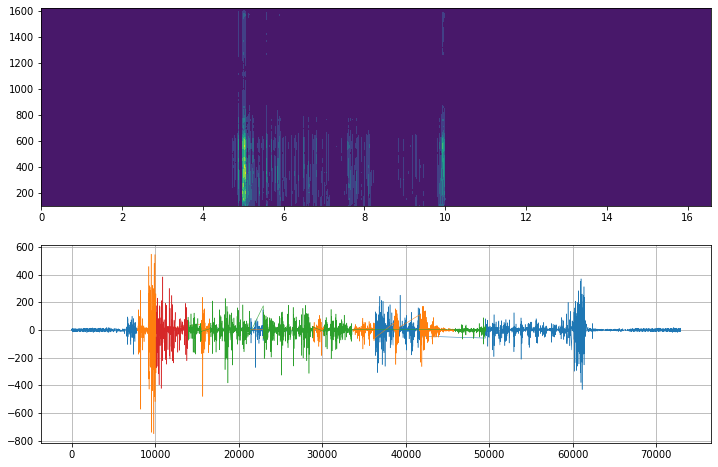

In [23]:
fc = pywt.central_frequency('mexh')
totalscal=32
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal, 1, -1)
t = np.arange(0,len(data)/1000,1e-3)

fn = 20
wn=2*fn/1000
b, a = signal.butter(4, wn, 'highpass')

for i in np.arange(3,11):
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    #x_filter = signal.filtfilt(b,a,data.iloc[:,i])
    #data.loc[:,data.columns[i]].plot(linewidth=0.5)
    cwtmatr,f = pywt.cwt(data.loc[:,data.columns[i]],scales,'morl',1e-3)
    plt.contourf(t, f, abs(cwtmatr))
    plt.subplot(2,1,2)
    for j in set(data.Label2):
        ind = data.Label2 == j
        data.loc[ind,data.columns[i]].plot(linewidth=0.5)
        #sns.lineplot(data.Time[ind],x_filter[ind],linewidth=0.3)
        #plt.ylim((-200,200))
        #plt.xlim((0,160000))
        plt.grid(True)
    #print(freqs[np.argmax(power)])

In [24]:
x.shape

(44530, 256, 8)

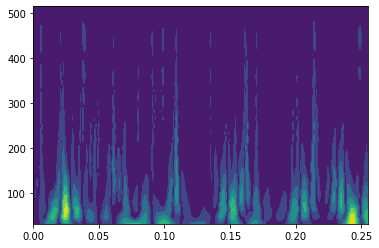

In [21]:
wave='mexh'
fc = pywt.central_frequency(wave)
totalscal=32
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal+1, 1, -1)
t = np.arange(0,0.256,1e-3)
cwtmatr,f = pywt.cwt(x[110,:,6],scales,wave,1e-3)
plt.contourf(t, f, abs(cwtmatr))

In [56]:
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [33]:
temp.shape

(2, 32, 256, 8)

In [41]:
temp=dp.generate_CWT_feature(x[100:102])

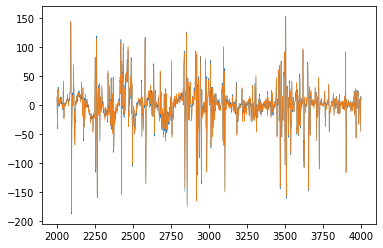

In [268]:
data.iloc[2000:4000,4].plot(linewidth=0.5)
plt.plot(np.arange(2000,4000),temp[2000:4000],alpha=0.9,linewidth=0.5)

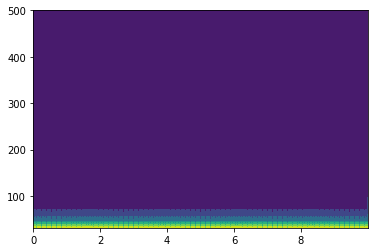

In [7]:
x = np.arange(0,10,0.001)
y = np.sin(2*np.pi*10*x)
fc = pywt.central_frequency('mexh')
totalscal=32
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal, 1, -1)
#plt.plot(y)
[cwtmatr, frequencies] = pywt.cwt(y,scales,'mexh',1e-3)
plt.contourf(x, frequencies, abs(cwtmatr))

In [13]:
f

array([500.   , 484.375, 468.75 , 453.125, 437.5  , 421.875, 406.25 ,
       390.625, 375.   , 359.375, 343.75 , 328.125, 312.5  , 296.875,
       281.25 , 265.625, 250.   , 234.375, 218.75 , 203.125, 187.5  ,
       171.875, 156.25 , 140.625, 125.   , 109.375,  93.75 ,  78.125,
        62.5  ,  46.875,  31.25 ])

11


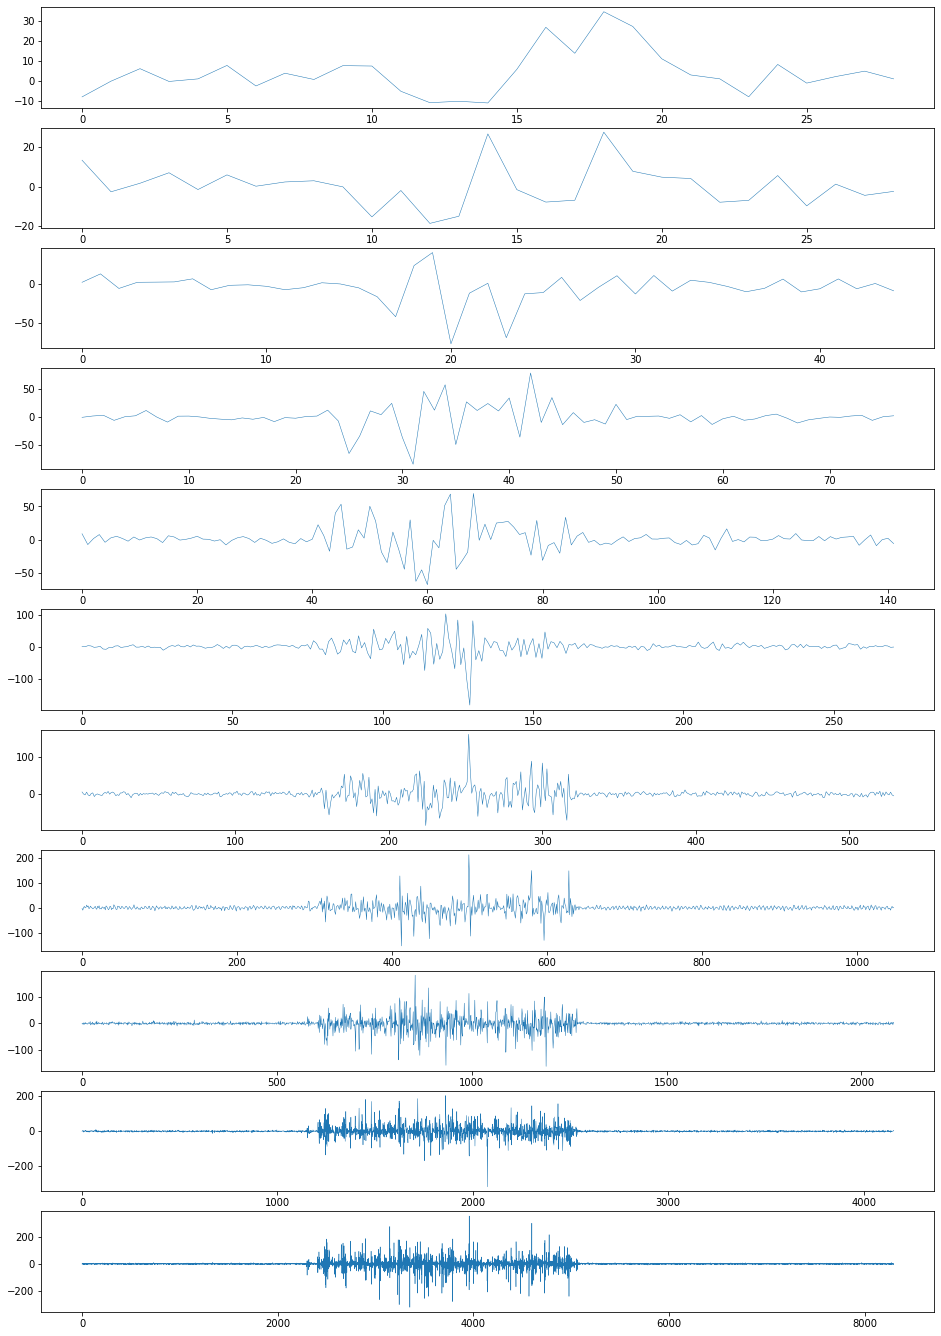

In [13]:
plt.figure(figsize=(16,24))
wa = pywt.wavedec(data.iloc[:,3],'db7',4,level=None)
j = 0
for i in wa:
    j += 1
    plt.subplot(len(wa),1,j)
    plt.plot(i,linewidth=0.5)
print(len(wa)) 

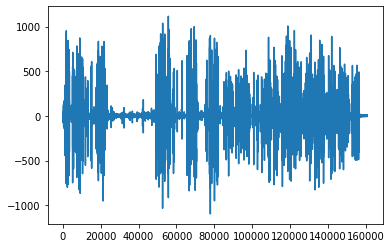

In [46]:
data.iloc[:,3].plot()

In [117]:
#for i in range(len(scs)):
#    joblib.dump(scs[i], './model/scalar%d'%i)
joblib.dump(sc, './model/scalar')

['./model/scalar']

In [15]:
data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [173]:
width = 1024
stride = 256
widths_scale = 32
x,y = dp.generate_window_slide_data(data,width,stride,scaler=True)

In [78]:
import time
import sys

In [96]:
start = time.time()
cwtmatr = generate_CWT_feature(x,widths_scale)
end = time.time()
duration = end-start
print('duration: %f'%(duration))

duration: 57.133043


In [ ]:
import h5py

file = './processed data/P812_trial_1_W%d_S%d_WS%d_CWT.hdf5'%(width,stride,widths_scale)
#with h5py.File(file,'w') as f:
#    f.create_dataset('cwt_data',data=cwtmatr)
#    f.create_dataset('label2',data=y)
    
with h5py.File(file,'r') as f:
    cwtmatr = f['cwt_data'][...]
    y = f['label2'][...]

In [20]:
dp.compute_AR(x).shape

(2196, 8)

1


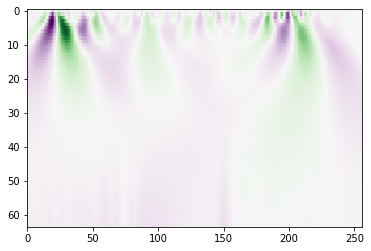

In [98]:
temp = 650
plt.imshow(cwtmatr[temp,:,:,0], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr[temp,:,:,0]).max(), 
           vmin=-abs(cwtmatr[temp,:,:,0]).max())
print(y[temp])

In [94]:
print('max: %f'%(cwtmatr.max()))

max: 10774.616683


In [93]:
sys.getsizeof(cwtmatr)

4601151632

In [20]:
path = './processed data/data_set_after_window.hdf5'
with h5py.File(path,'r') as f:
    x = f['cwt_data'][...]
    y = f['label2'][...]

In [22]:
x.shape

(44530, 256, 8)

In [4]:
feature = dp.generate_feature(x)

In [5]:
ind = (y==2)

In [8]:
ind2 = (y==0)

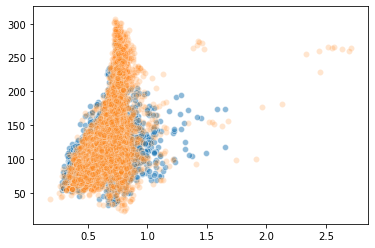

In [45]:
f1 = 8
f2 = 40
sns.scatterplot(feature[ind,f1],feature[ind,f2],alpha=0.5)
sns.scatterplot(feature[ind2,f1],feature[ind2,f2],alpha=0.2)

In [28]:
a = np.array([1,2,3,4])
ak,sig = autoregressive.AR_est_YW(a,3)

In [29]:
a[:3]@ak+sig

4.373102815177478

In [30]:
dwt = pywt.wavedec(x[1,:,1],wavelet='db7',level=3)

In [56]:
temp = np.array(dwt[0])
for i in range(len(dwt)-1):
    temp = np.concatenate([temp,np.array(dwt[i+1])])
l=0
for i in dwt:
    l+=len(i)
    print(len(i))

43
43
73
134


In [57]:
len(temp)

293

In [82]:
np.clip(np.random.randint(-5,5,(3,3)),0,4)

array([[0, 2, 0],
       [0, 3, 4],
       [3, 0, 0]])

In [21]:
def featureZC(data, threshold=10e-7):
    numOfZC = []
    channel = data.shape[1]
    length  = data.shape[0]
    
    for i in range(channel):
        count = 0
        for j in range(1,length):
            diff = data[j,i] - data[j-1,i]
            mult = data[j,i] * data[j-1,i]
            
            if np.abs(diff)>threshold and mult<0:
                count=count+1
        numOfZC.append(count)
    return np.array(numOfZC)

In [26]:
featureZC(x[0,:,:])

array([40, 43, 31, 52, 44, 76, 55, 62])

In [25]:
dp.compute_ZC(x,1e-7)[0,:]

array([ 73,  86,  39,  96,  95, 120, 110, 111])

In [26]:
a=[]
b=np.random.randint(0,10,(3,3,3))
c=np.random.randint(0,10,(3,3,3))
len(np.array(c.tolist() + b.tolist()))

6

In [18]:
a=pd.read_csv('./index_wrong_predict_ann.csv')
c=pd.read_csv('./index_wrong_predict_cnn.csv')

In [125]:
#(pd.concat([a,c],axis=0).iloc[:,0].value_counts()==2).value_counts()
x,y = dp.generate_window_slide_data_time_continue_fremove(data,width=1024,
                                        stride=512,
                                        scaler=False,
                                        same_label=True)

In [46]:
def detrend(signal, Lambda,return_trend=False):
    """detrend(signal, Lambda) -> filtered_signal
  
    This function applies a detrending filter.
   
    This code is based on the following article "An advanced detrending method with application
    to HRV analysis". Tarvainen et al., IEEE Trans on Biomedical Engineering, 2002.
  
    **Parameters**

    ``signal`` (1d numpy array):
    The signal where you want to remove the trend.

    ``Lambda`` (int):
    The smoothing parameter.

    **Returns**
  
    ``filtered_signal`` (1d numpy array):
    The detrended signal.
    """
    signal_length = signal.shape[0]
    #signal_res = signal.reshape
    # observation matrix
    H = np.identity(signal_length) 

    # second-order difference matrix
    from scipy.sparse import spdiags
    ones = np.ones(signal_length)
    minus_twos = -2*np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index, (signal_length-2), signal_length).toarray()
    filtered_signal = (H - np.linalg.inv(H + (Lambda**2) * D.T@D))@signal
    if return_trend:
        trend = (np.linalg.inv(H + (Lambda**2) * D.T@D))@signal
        return filtered_signal,trend
    else:
        return filtered_signal

In [71]:
start = time.time()
temp_tdt,trend=detrend(x[0,:,:],300,True)
end = time.time()
print(end-start)
temp_tdt.shape

1.0781865119934082


(1024, 8)

In [88]:
x_f = signal.filtfilt(b,a,x[0,:,1])


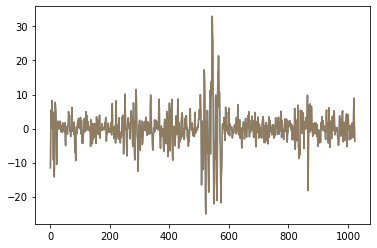

In [92]:
plt.plot(signal.filtfilt(b,a,temp_tdt[:,1]))
#plt.plot(temp_tdt[:,1])
#plt.plot(x[0,:,1])
#plt.plot(trend[:,1])
plt.plot(detrend(x_f,300),alpha=0.5)

In [5]:
#temp=sc.fit_transform(np.array(data.loc[:,data.columns[4]]).reshape(1,-1))[0,:]
temp=data.loc[:,data.columns[6]]
#temp_td,trend=detrend(temp[:15000],200)
trend_con = np.zeros((0,))
temp_con = np.zeros((0,))
length = 1000
for i in range(np.ceil(len(temp)/length).astype('int')):
    #print(temp[i*length:(i+1)*length].shape)
    temp_tdt,trend_t=detrend(temp[i*length:(i+1)*length],40)
    trend_con = np.concatenate([trend_con,trend_t])
    temp_con = np.concatenate([temp_con,temp_tdt])

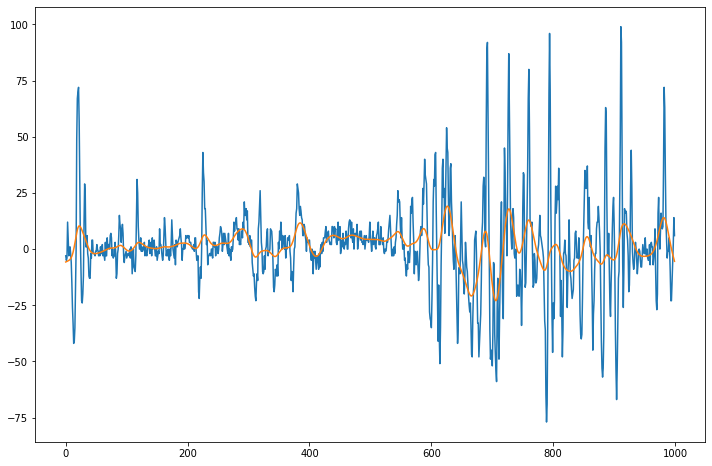

In [6]:
plt.figure(figsize=(12,8))
plt.plot(np.array(temp[3000:4000]))
plt.plot(trend_con[3000:4000])
#plt.ylim([-500,500])

In [146]:
temp=normalize(np.array(data.loc[:,data.columns[4]:]),axis=0)

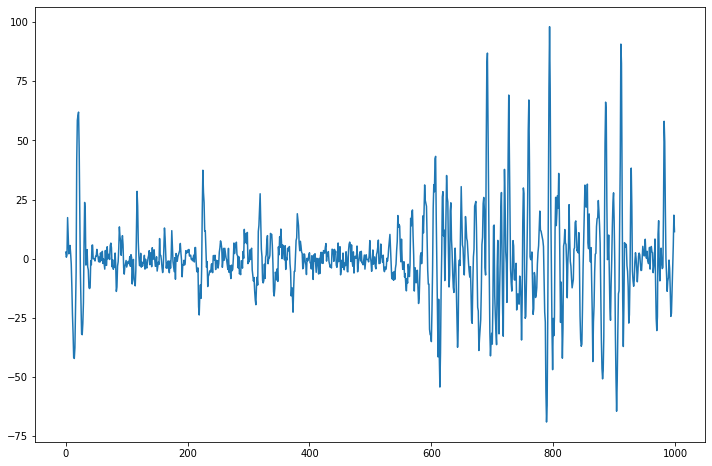

In [7]:
plt.figure(figsize=(12,8))
#plt.plot(temp[:,2])
plt.plot(np.array(temp_con[3000:4000]))
#plt.ylim([-500,500])

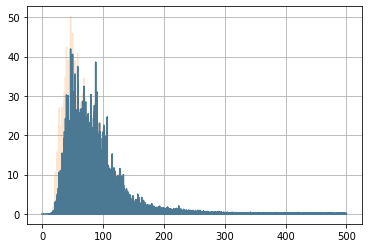

In [10]:
fn = 20
wn=2*fn/1000
b, a = signal.butter(4, wn, 'highpass')
x_filter = signal.filtfilt(b,a,temp)

freqs,power = signal.periodogram(temp,1e3)
freqs2,power2 = signal.periodogram(temp_con,1e3)
freqs3,power3 = signal.periodogram(x_filter,1e3)
#plt.plot(freqs,power)
plt.plot(freqs2,power2,alpha=1)
plt.plot(freqs3,power3,alpha=0.2)
plt.grid(True)
#plt.ylim((0,5))

In [45]:
temp.shape

(25322,)

In [62]:
np.ceil(2.1).astype('int')

3

In [5]:
length = 1000
lamb = 50
for file in df.columns[2:]:
    data = pd.read_csv('./data/'+file)
    data = data.dropna()
    
    trend_con = np.zeros((0,))
    temp_con = np.zeros((0,))
    m = 0
    total = np.ceil(len(data)/length).astype('int')
    for col in data.columns[3:]:
        #trend_con = np.zeros((0,))
        temp_con = np.zeros((0,))
        for i in range(total):
            temp = data.loc[:,col]
            temp_tdt,_=detrend(temp[i*length:(i+1)*length],lamb)
            #trend_con = np.concatenate([trend_con,trend_t])
            temp_con = np.concatenate([temp_con,temp_tdt])
            
            if m+1 == total*8:
                percent = 100.0
                print('%s [%d/%d]'%(str(percent)+'%',m+1,total*8),end='\n')
            else:
                percent = round(1.0 * m / total/8 * 100,2)
                print('%s [%d/%d]'%(str(percent)+'%',m+1,total*8),end='\r')
            m += 1
        data.loc[:,col] = temp_con
    data.to_csv('./data/detrend/detrend_%d_'%lamb+file,index=False)

100.0% [288/288]
100.0% [256/256]
100.0% [248/248]
100.0% [1280/1280]
100.0% [1808/1808]
100.0% [2904/2904]
100.0% [232/232]
100.0% [168/168]
100.0% [208/208]
100.0% [200/200]
100.0% [176/176]
100.0% [224/224]
100.0% [224/224]
100.0% [208/208]
100.0% [216/216]
100.0% [720/720]
100.0% [568/568]
100.0% [640/640]
100.0% [592/592]


In [140]:
data

Time  Label1  Label2  LEFT_TA  LEFT_TS  LEFT_BF  LEFT_RF  RIGHT_TA  \
0       0.000       0       0     -1.0      1.0    -11.0       -4         2   
1       0.001       0       0      3.0     -2.0     20.0        0        -1   
2       0.002       0       0      2.0      0.0      8.0        0        -1   
3       0.003       0       0     -3.0      0.0     15.0       -2        -2   
4       0.004       0       0      3.0      0.0      9.0        0        -2   
...       ...     ...     ...      ...      ...      ...      ...       ...   
35125  35.125       0       0     -2.0     -1.0      0.0       -2         4   
35126  35.126       0       0     -7.0     -1.0      0.0       -9         3   
35127  35.127       0       0    -11.0      2.0      2.0       -5         0   
35128  35.128       0       0    -12.0      1.0      0.0       -4         3   
35129  35.129       0       0     -2.0    -10.0      0.0       -2         0   

       RIGHT_TS  RIGHT_BF  RIGHT_RF  
0           2.0         0         0  
1           0.0         0         6  
2           2.0        -1         7  
3           5.0        -3         0  
4          -5.0        -3        -2  
...         ...       ...       ...  
35125       2.0        -2         4  
35126      -3.0         1        16  
35127       1.0        -3        20  
35128       2.0        -6        19  
35129      11.0         0        12  

[35121 rows x 11 columns]

In [93]:
#from nolds import sampen, corr_dim, dfa
from scipy.stats import kurtosis
from sklearn.linear_model import RANSACRegressor
#from corr_dim import *
import measures
import imp
imp.reload(corr_dim)

NameError: name 'corr_dim' is not defined

In [47]:
import math
from statsmodels.tsa.tsatools import lagmat
from sklearn.metrics.pairwise import euclidean_distances as dist
from mpl_toolkits.mplot3d import Axes3D

def Dim_Corr(datas, Tao, m, graph=False): 
    """
    Compute the correlation dimension of a time series with a time-lag Tao and an embedding dimension m
    datas--> time series to compute the correlation dimension
    Tao--> time lag computed using the first zero crossing of the auto-correlation function (see Tao func)   
    m--> embeding dimension of the time-series, computed using the false neighbors method (see fnn func)  
    graph (optional)--> plot the phase space (attractor) in 3D
    """
    x=corr_dim.PhaseSpace(datas, m, Tao, graph)
    ED2=dist(x.T)
    print(ED2.shape)
    posD=np.triu_indices_from(ED2, k=1)
    ED=ED2[posD]
    max_eps=np.max(ED)
    min_eps=np.min(ED[np.where(ED>0)])
    max_eps=np.exp(math.floor(np.log(max_eps)))
    n_div=int(math.floor(np.log(max_eps/min_eps)))
    n_eps=n_div+1
    eps_vec=range(n_eps)
    unos=np.ones([len(eps_vec)])*-1
    eps_vec1=max_eps*np.exp(unos*eps_vec-unos)
    Npairs=((len(x[1,:]))*((len(x[1,:])-1)))
    C_eps=np.zeros(n_eps)
 
    for i in eps_vec:
            eps=eps_vec1[i]
            N=np.where(((ED<eps) & (ED>0)))
            S=len(N[0])
            C_eps[i]=float(S)/Npairs

    omit_pts=1 
    k1=omit_pts
    k2=n_eps-omit_pts
    xd=np.log(eps_vec1)
    yd=np.log(C_eps)
    xp=xd[k1:k2]
    yp=yd[k1:k2]
    print(k2.shape)
    p = np.polyfit(xp, yp, 1)
    return p[0]

In [293]:
#plt.plot(x[1,:,2])
#corr_dim(x[1,:,2].reshape(-1,1),emb_dim=2,debug_plot =True)
tau = corr_dim.Tao(x[100,:,1])
m = corr_dim.fnn(x[100,:,1],200)
measures.corr_dim(x[100,:,1], emb_dim=5, lag=4,debug_plot=True)
#corr_dim.Dim_Corr(x[1,:,2],20,1,True)

ZeroDivisionError: float division by zero

0

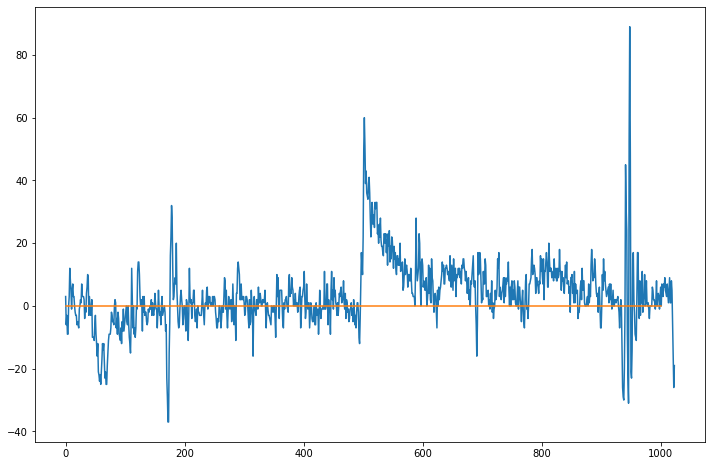

In [159]:
plt.figure(figsize=(12,8))
temp = x[199,:,0]
plt.plot(temp)
plt.plot([0,1000],[0,0])
temp_tdt,trend=detrend(temp,50,True)
#plt.plot(temp_tdt)
#plt.ylim((-5,5))
y[5]

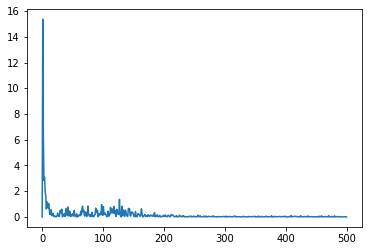

In [128]:
fn = 20
wn=2*fn/1000
b, a = signal.butter(4, wn, 'highpass')
#x_filter = signal.filtfilt(b,a,temp)
ind = y==1
freqs,power = signal.periodogram(x[ind][-1,:,0],1e3)
plt.plot(freqs,power)

In [129]:
for j in range(8):
    freqs, power=signal.periodogram(x[ind][-1,:,j], 1e3)
    ind_l = freqs<30
    max_l = np.max(power[ind_l])
    max_h = np.max(power[~ind_l])
    if (max_l>3*max_h) | (max_h<0.5):
        print('skip')
        break

skip


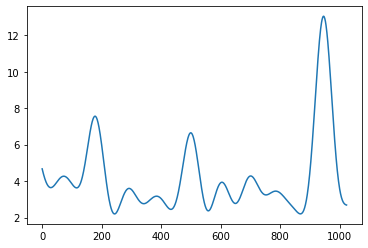

In [158]:
plt.plot(dp.rectify_emg(temp_tdt,10))

In [139]:
data1 = x[1,:,2]
ld=len(data1)
m=20
Tao=5
xx = np.zeros([(ld-(m-1)*Tao),m])
for j in range(ld-(m-1)*Tao):
    #print(j)
    l1=(j)
    l2=(j+m*Tao)
    ind = np.arange(l1,l2,Tao)
    #print(ind)
    xx[j,:]=data1[ind]

In [123]:
ED2=dist(xx)
posD=np.triu_indices_from(ED2, k=1)
ED=ED2[posD]

In [140]:
ED2

array([[0.        , 4.24526665, 5.34781054, ..., 5.46366098, 6.69938521,
        6.18075125],
       [4.24526665, 0.        , 5.24931571, ..., 5.39315923, 6.47222107,
        7.5721411 ],
       [5.34781054, 5.24931571, 0.        , ..., 4.93502235, 5.68216823,
        6.95920631],
       ...,
       [5.46366098, 5.39315923, 4.93502235, ..., 0.        , 2.53016596,
        5.01890952],
       [6.69938521, 6.47222107, 5.68216823, ..., 2.53016596, 0.        ,
        5.91026481],
       [6.18075125, 7.5721411 , 6.95920631, ..., 5.01890952, 5.91026481,
        0.        ]])

In [135]:
for i in np.linspace(-4,4,11):
    dp.compute_ZC(x,i)

In [131]:
a=np.ones((4,4))
posa=np.triu_indices_from(a, k=1)

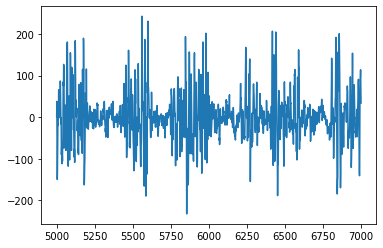

In [275]:
temp = 

In [150]:
temp=dp.compute_ZC_expand(x,np.linspace(-4,4,11))

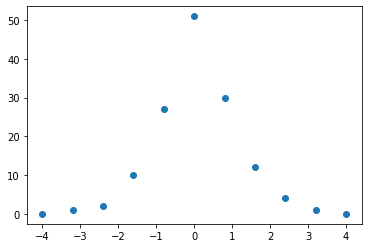

In [71]:
plt.scatter(np.linspace(-4,4,11),temp[500,:,1])

In [4]:
emd=EMD()

In [ ]:
imf = emd(np.array(data.iloc[:2000,4:6]))

In [13]:
imf.shape

(9, 2000)

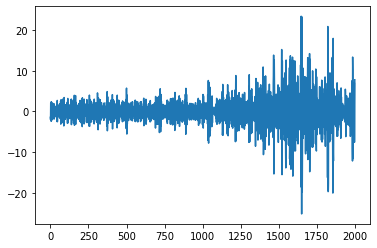

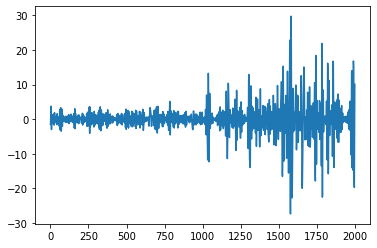

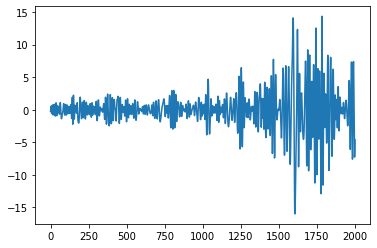

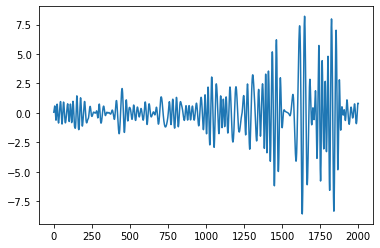

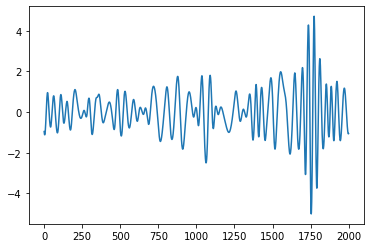

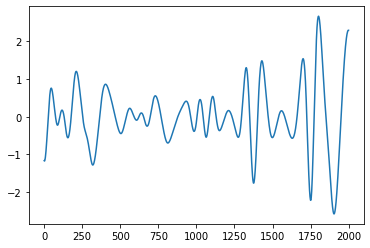

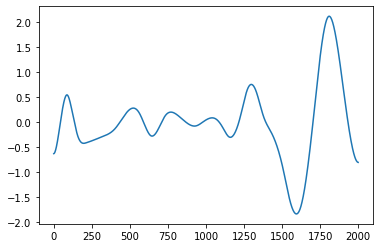

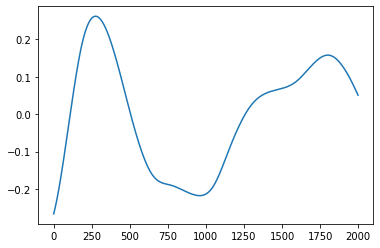

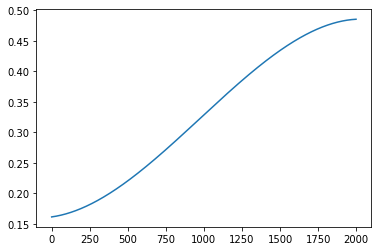

In [14]:
for i in range(len(imf)):
    plt.figure()
    plt.plot(imf[i,:])

In [5]:
3/10*np.log2(3/10)+7/10*np.log2(7/10)

-0.8812908992306927

In [6]:
(5.7-7.5)**2+(5.91-7.5)**2+(6.4-7.5)**2+(6.8-7.5)**2+(7.05-7.5)**2+(8.9-7.5)**2+(8.7-7.5)**2+(9-7.5)**2+(9.05-7.5)**2

15.723099999999999

(1500, 3500)

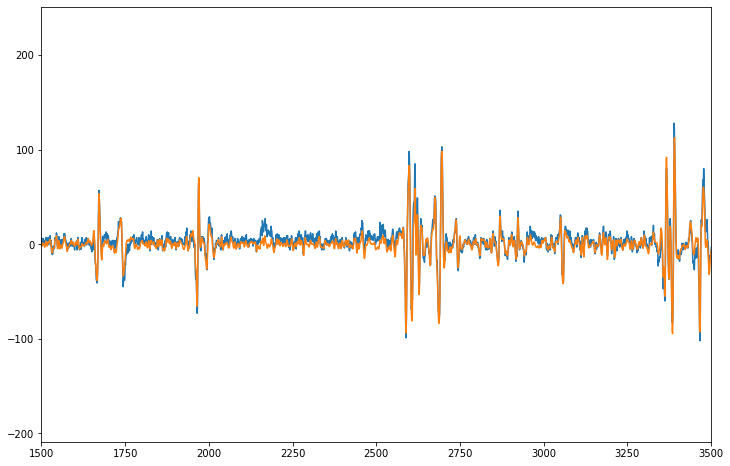

In [90]:
label = 1
i=30
ind = (data.Label1==label) & (data.Label2==label)
plt.figure(figsize=(12,8))
data.loc[ind,data.columns[7]].reset_index(drop=True).plot()
fn = 20
wn=2*fn/1000
fn1 = 200
wn1=2*fn1/1000
b, a = signal.butter(4, [wn,wn1], 'bandpass')
x_filter = signal.filtfilt(b, a, data.loc[ind,data.columns[7]].reset_index(drop=True))
plt.plot(x_filter)
#plt.xlim((i*256+0,i*256+1024))
plt.xlim((1500,3500))

(0, 3000)

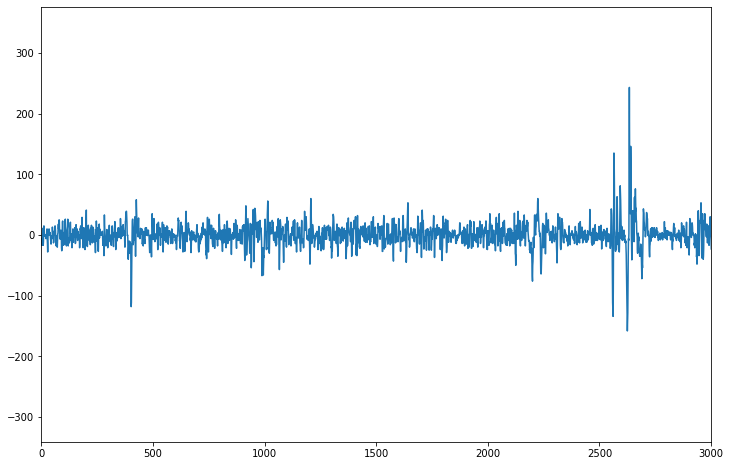

In [25]:
label = 2
ind = (data.Label1==label) & (data.Label2==label)
plt.figure(figsize=(12,8))
data.loc[ind,data.columns[4]].reset_index(drop=True).plot()
plt.xlim((0,3000))

(0, 1024)

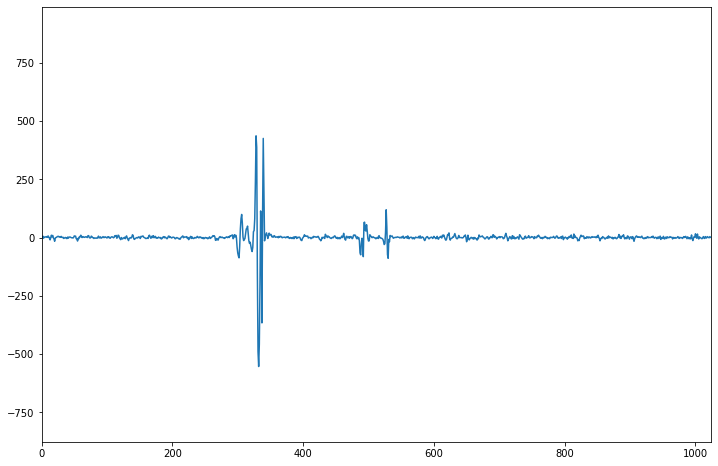

In [29]:
label = 6
ind = (data.Label1==label) & (data.Label2==label)
plt.figure(figsize=(12,8))
data.loc[ind,'LEFT_TA'].reset_index(drop=True).plot()
plt.xlim((0,1024))

In [46]:
a = np.array([1,1,1,1,11,1,1,11,11,])
np.unique(a, return_counts=True)

(array([ 1, 11]), array([6, 3], dtype=int64))

In [60]:
temp=data.Label2[500*256:500*256+1024].value_counts()


In [69]:
temp.index[temp.argmax()]

2

In [64]:
temp.argmax()

0

In [7]:
data.Time[0:1000]

0      0.000
1      0.001
2      0.002
3      0.003
4      0.004
       ...  
995    0.995
996    0.996
997    0.997
998    0.998
999    0.999
Name: Time, Length: 1000, dtype: float64

In [63]:
(np.round((np.array(data.Time[1:]))-(np.array(data.Time[:-1])),3)>0.001).any()

True

In [50]:
((np.array(data.Time[1:])-np.array(data.Time[:-1])))[-1]

0.0010000000000047748

In [55]:
np.round((np.array(data.Time[1:]))-(np.array(data.Time[:-1])),3)[-1]

0.001

In [53]:
np.round(np.array(data.Time[:-1]),3)

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 8.9722e+01, 8.9723e+01,
       8.9724e+01])

In [66]:
if (np.round(np.array(data.Time[1:])-np.array(data.Time[:-1]),3)>0.001).any():
    print('true')

true


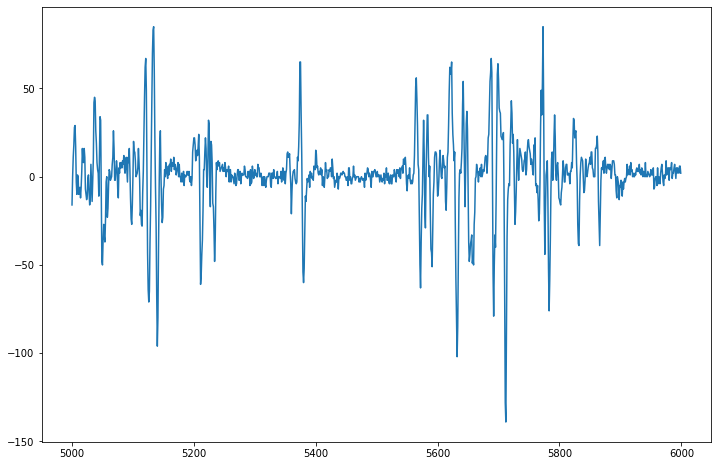

In [45]:
plt.figure(figsize=(12,8))
data.iloc[5000:6000,10].plot()

In [193]:
def filteremg(emg, low_pass=10, sfreq=1000, high_band=20, low_band=450):
    """
    time: Time data
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    time = np.arange(0,len(emg)/1000,1e-3)
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
#     b1, a1 = signal.butter(4, [high_band,low_band], btype='bandpass')
    b1, a1 = signal.butter(4, [low_band], btype='lowpass')
    
    # process EMG signal: filter EMG
    #emg_filtered = signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    #low_pass = low_pass/(sfreq/2)
    #b2, a2 = signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = dp.mean_smooth(emg_rectified,low_pass)
    return emg_envelope
    # plot graphs
#     fig = plt.figure()
#     plt.subplot(1, 4, 1)
#     plt.subplot(1, 4, 1).set_title('Unfiltered,' + '\n' + 'unrectified EMG')
#     plt.plot(time, emg)
#     plt.locator_params(axis='x', nbins=4)
#     plt.locator_params(axis='y', nbins=4)
#     #plt.ylim(-1.5, 1.5)
#     plt.xlabel('Time (sec)')
#     plt.ylabel('EMG (a.u.)')
    
#     plt.subplot(1, 4, 2)
#     plt.subplot(1, 4, 2).set_title('Filtered,' + '\n' + 'rectified EMG: ' + str(int(high_band*sfreq)) + '-' + str(int(low_band*sfreq)) + 'Hz')
#     plt.plot(time, emg_rectified)
#     plt.locator_params(axis='x', nbins=4)
#     plt.locator_params(axis='y', nbins=4)
#     #plt.ylim(-1.5, 1.5)
#     plt.plot([0.9, 1.0], [1.0, 1.0], 'r-', lw=5)
#     plt.xlabel('Time (sec)')

#     plt.subplot(1, 4, 3)
#     plt.subplot(1, 4, 3).set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(low_pass*sfreq)) + ' Hz')
#     plt.plot(time, emg_envelope)
#     plt.locator_params(axis='x', nbins=4)
#     plt.locator_params(axis='y', nbins=4)
#     #plt.ylim(-1.5, 1.5)
#     plt.plot([0.9, 1.0], [1.0, 1.0], 'r-', lw=5)
#     plt.xlabel('Time (sec)')
    
#     plt.subplot(1, 4, 4)
#     plt.subplot(1, 4, 4).set_title('Focussed region')
#     plt.plot(time[int(0.9*1000):int(1.0*1000)], emg_envelope[int(0.9*1000):int(1.0*1000)])
#     plt.locator_params(axis='x', nbins=4)
#     plt.locator_params(axis='y', nbins=4)
#     #plt.xlim(0.9, 1.0)
#     #plt.ylim(-1.5, 1.5)
#     plt.xlabel('Time (sec)')

#     fig_name = 'fig_' + str(int(low_pass*sfreq)) + '.png'
#     fig.set_size_inches(w=11,h=7)
#     fig.savefig(fig_name)

# show what different low pass filter cut-offs do
# for i in [3, 10, 40]:
#     filteremg(time, emg_correctmean, low_pass=i)
    
recti = filteremg(x,30)

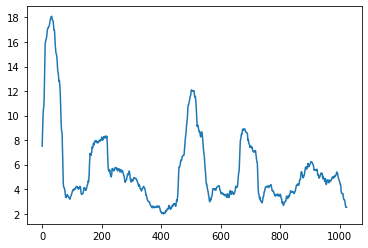

In [195]:
plt.plot(recti[10,:,1])

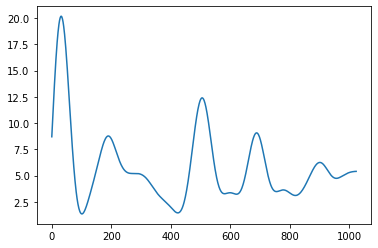

In [196]:
plt.plot(dp.rectify_emg(x[10,:,1]))

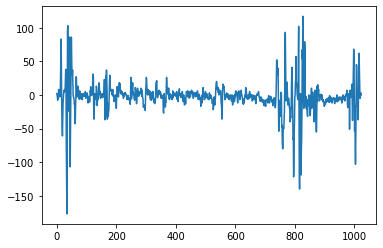

In [106]:
plt.plot(x[5,:,0])

In [126]:
len(x)

261